# Perkenalan

==========================================================

Graded Challenge 7

Nama  : Muhammad Insani

Batch : HCK-010

Program ini dibuat untuk memprediksi jenis kelamin, etnis, dan usia berdasarkan foto yang diupload atau didapatkan dari url gambar

===========================================================

## Deskripsi Dataset

Dataset CSV gambar wajah yang diberi label berdasarkan usia, jenis kelamin, dan etnis. didalam dataset ini mencakup 27305 baris dan 5 kolom, berikut link datasetnya : [AGE, GENDER AND ETHNICITY (FACE DATA).CSV](https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv)

| Nama Kolom | Deskripsi                                   |
|------------|---------------------------------------------|
| age        | Usia subjek pada foto wajah                 |
| ethnicity  | Ras/etnisitas subjek foto (0:White, 1:Black, 2:Asian, 3:Indian, 4:Others)                   |
| gender     | Jenis kelamin subjek foto (0:Male, 1:Female)                   |
| img_name   | Nama file unik untuk tiap gambar            |
| pixels     | Matrix nilai pixel gambar (0-255)            |

## Disclaimer

Dikarenakan dataset saya mempunyai 3 target, saya akan mengerjakan model prediksi dengan menggunakan 3 target tersebut dalam pengerjaan ini, tetapi saya lebih mempriotaskan terhadap target gender dan target lainnya sebagai latihan saya untuk lebih memahami materi cnn

# Import Libraries

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,GlobalAveragePooling2D,Lambda,Dropout
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import requests
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [3]:
data = pd.read_csv('age_gender.csv')
data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


Dataset memiliki 3 target yaitu age,ethnicity, dan gender

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


Terdapat 23705 value data pada dataset

In [5]:
data.isnull().sum()

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

Tidak terdapat data null

In [6]:
data.nunique()

age            104
ethnicity        5
gender           2
img_name     23479
pixels       23315
dtype: int64

data target untuk gender merupakan binary,sedangkan target age dan ethnicity merupakan multi

In [7]:
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


tidak terdapat data duplicates pada dataset

# Exploratory Data Analysis (EDA)

## Distribution Target

In [8]:
data.describe()

,age,ethnicity,gender
count,23705.000000,23705.000000,23705.000000
mean,33.300907,1.269226,0.477283
std,19.885708,1.345638,0.499494
min,1.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000
50%,29.000000,1.000000,0.000000
75%,45.000000,2.000000,1.000000
max,116.000000,4.000000,1.000000


Target age memiliki varians yang cukup banyak dibandingkan target lain, dan untuk target age persebarannya lebih banyak pada umur dibawah 30 tahunan, sedangakan untuk target ethnicity persebarannya lebih banyak pada label dibawah 1 dan terakhir untuk target gender persebarannya lebih banyak pada label 0

In [9]:
data['age_'] = data['age'].apply(
    lambda age: 0 if age <= 2 else 
    (1 if age <= 12 else 
    (2 if age <= 18 else 
    (3 if age <= 60 else 
    4))))

## calculating distributions
age_dist = data['age'].value_counts()
age_cat_dist = data['age_'].value_counts().rename(index={0:'Baby', 1:'Childrens', 2:'Teens', 3:'Adults', 4:'Elderly'})
ethnicity_dist = data['ethnicity'].value_counts().rename(index={0:'White', 1:'Black', 2:'Asian', 3:'Indian', 4:'Others'})
gender_dist = data['gender'].value_counts().rename(index={0:'Male',1:'Female'})

def distribution_plot(x, y, name):
    plt.bar(x, y)
    plt.title(name)
    plt.show()

## Age Distribution

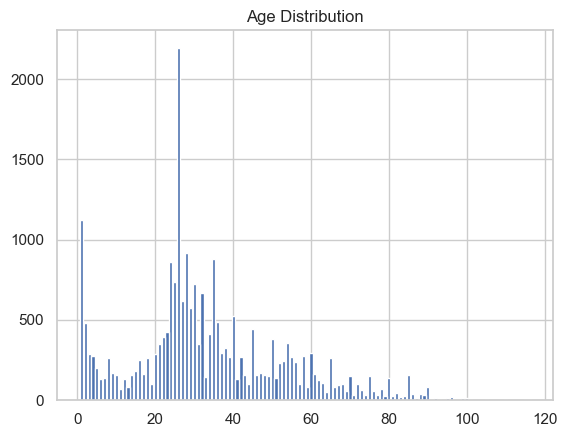

In [95]:
distribution_plot(x=age_dist.index, y=age_dist.values, name='Age Distribution')

Berdasarkan visualisasi distribusi umur pada dataset sangat bervariasi, dengan rentang umur mulai dari 1 tahun hingga 116 tahun. Umur 26 tahun menjadi umur yang paling umum muncul dengan jumlah data sebanyak 2.197, diikuti oleh umur 1 tahun dengan 1.123 data, dan umur 28 tahun dengan 918 data. Perlu diperhatikan bahwa ada variasi yang signifikan dalam jumlah data untuk setiap umur, dan perlu dilakukan strategi pengelompokan umur yang cermat agar model dapat mengatasi variasi tersebut dengan baik.

## Age Category Distribution

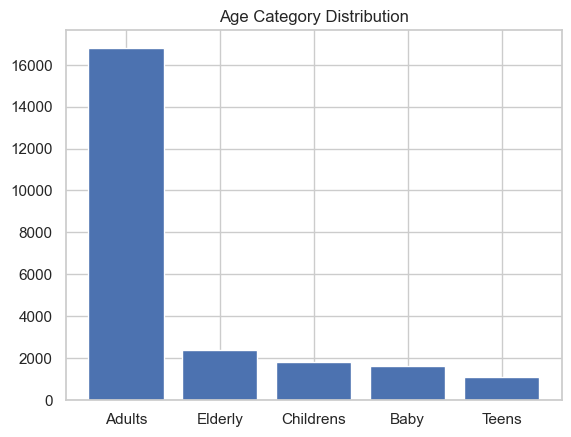

In [96]:
distribution_plot(x=age_cat_dist.index, y=age_cat_dist.values, name='Age Category Distribution')

Berdasarkan visualisasi distribusi label kategori umur pada dataset, kategori Adults mendominasi dengan jumlah data sebanyak 16.815, menjadi kelompok terbesar di antara kategori umur lainnya. Disusul oleh kategori Elderly dengan 2.395 data, Childrens dengan 1.808 data, Baby dengan 1.605 data, dan Teens dengan 1.082 data. Dengan demikian, fokus pada kelompok Adults menjadi krusial dalam pengembangan model, namun tetap perlu memperhitungkan representasi yang cukup dari kelompok umur lainnya agar model dapat memberikan prediksi yang lebih seimbang untuk semua kategori umur.

## Ethnicity Distribution

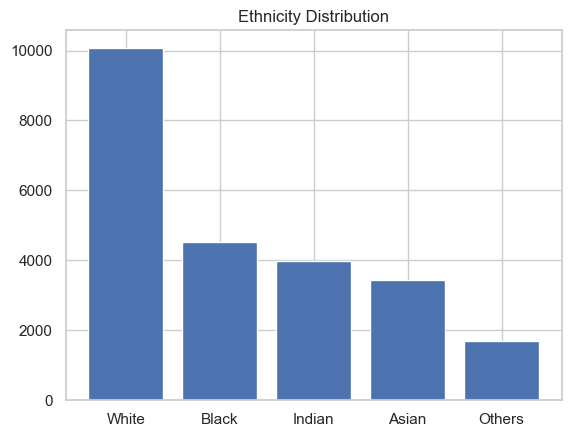

In [97]:
distribution_plot(x=ethnicity_dist.index, y=ethnicity_dist.values, name='Ethnicity Distribution')

Berdasarkan visualisasi, dapat dilihat bahwa distribusi target ethnicity dalam dataset sangat tidak seimbang. Label white mendominasi dengan jumlah data sebanyak 10.078, lebih dari dua kali lipat dari label black yang merupakan label kedua terbanyak dengan jumlah 4.526 data. Sementara itu, label Asian memiliki 3.434 data, Indian 3.975 data, dan Others 1.692 data. Ketidakseimbangan ini perlu diperhatikan dalam pengembangan model, karena dapat mempengaruhi kinerja dan generalisasi model terhadap kelompok etnis yang kurang representatif. Strategi untuk mengatasi ketidakseimbangan ini mungkin melibatkan teknik oversampling atau undersampling pada kelompok etnis yang kurang representatif.

## Gender Distribution

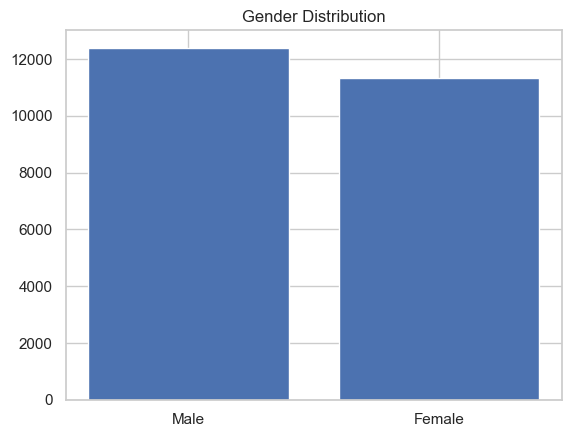

In [98]:
distribution_plot(x=gender_dist.index, y=gender_dist.values, name='Gender Distribution')

Berdasarkan visualisasi yang terlihat, dapat diambil kesimpulan bahwa distribusi label antara male dan female cenderung seimbang, dengan jumlah male sekitar 12.391 dan female sekitar 11.314. Hal ini menunjukkan proporsi yang relatif seragam antara kedua kategori, menciptakan keseimbangan dalam representasi jenis kelamin dalam dataset tersebut.

## Distribution Shape size

In [14]:
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))
data['pixels'][0].shape

(2304,)

panjang array dalam  kolom 'pixels' adalah 2304, itu berarti array tersebut mewakili citra dengan ukuran 48x48 pixel, karena 48 * 48 = 2304

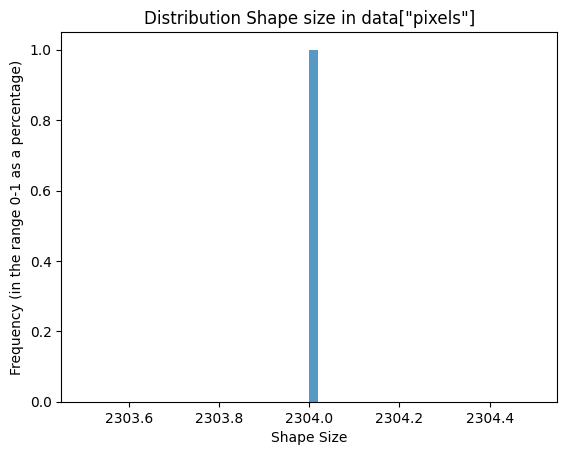

In [15]:
shapes = set(data['pixels'][i].shape for i in range(len(data['pixels'])))

plt.hist(shapes, bins=50, alpha=0.75)
plt.title('Distribution Shape size in data["pixels"]')
plt.xlabel('Shape Size')
plt.ylabel('Frequency (in the range 0-1 as a percentage)')
plt.show()


Berdasarkan pengamatan visual dari representasi data piksel, dapat disimpulkan bahwa panjang array piksel secara keseluruhan menunjukkan konsistensi yang signifikan, yakni seluruhnya memiliki nilai 2304. Hal ini mencerminkan dimensi gambar secara keseluruhan, setara dengan ukuran 48x48 piksel. Temuan ini menggambarkan konsistensi yang dapat diandalkan dalam struktur dan ukuran data piksel pada seluruh dataset, memberikan pandangan yang stabil terhadap setiap komponen gambar yang diamati dalam analisis.

## Overview of Photo Characteristics

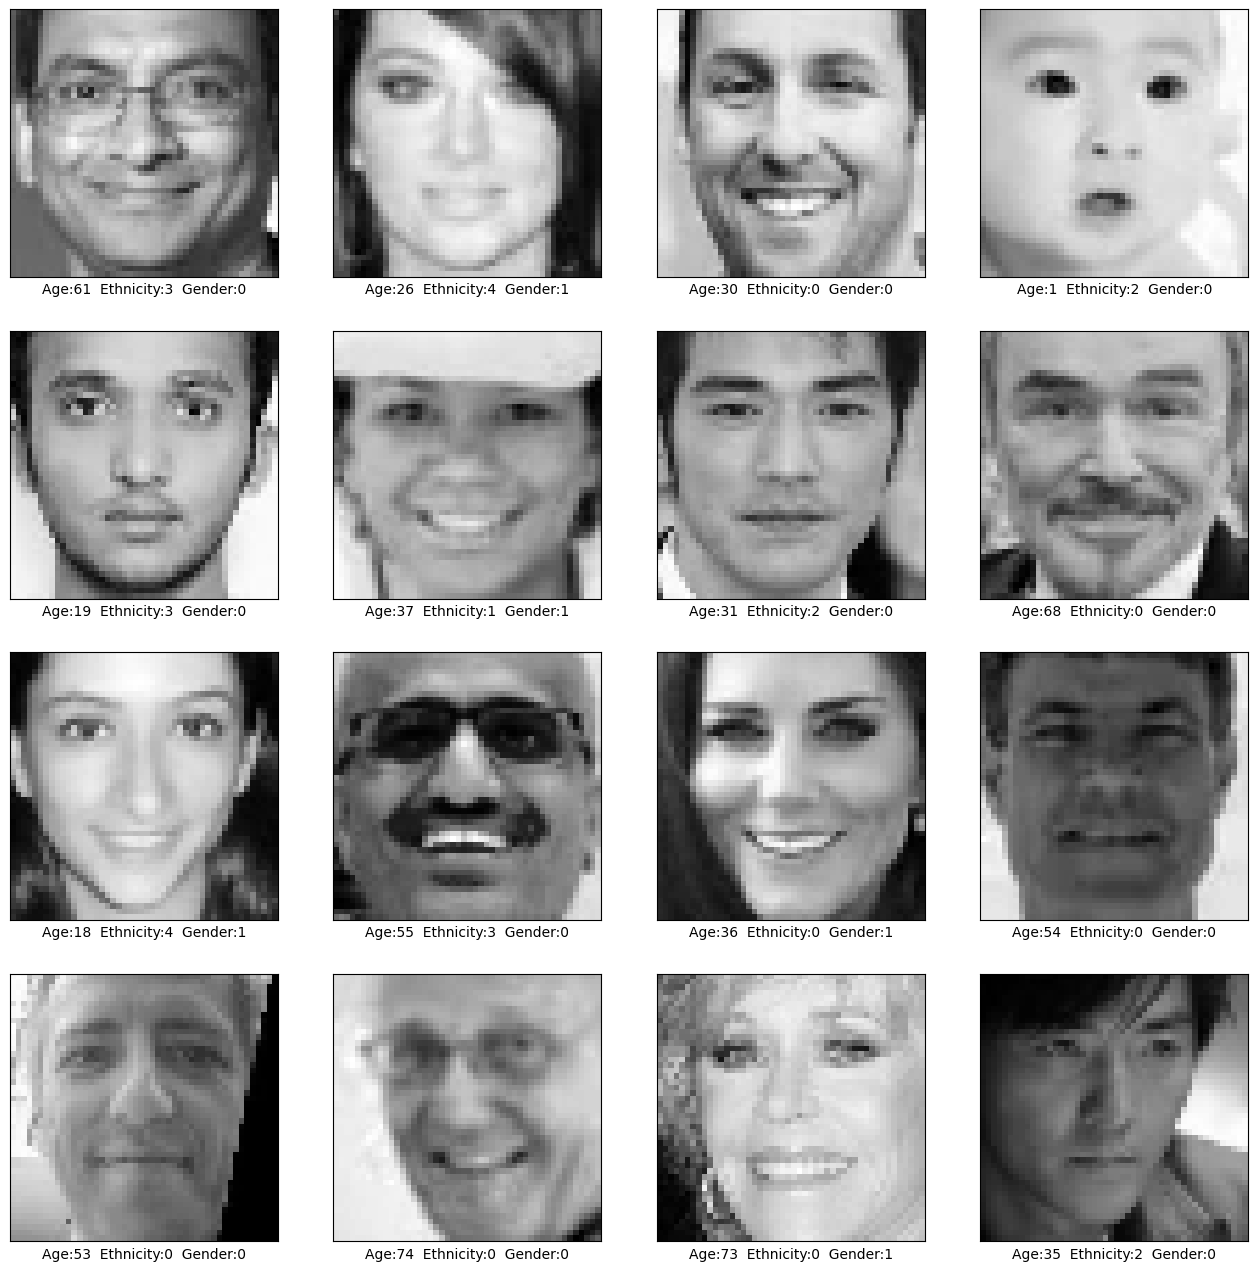

In [16]:
plt.figure(figsize=(16,16))

for i in range (16):
    index=np.random.randint(0,23000,1)
    random_picking = index
    for a in (random_picking):
        plt.subplot(4,4,(i%25)+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(data['pixels'].iloc[a].reshape(48,48), cmap='gray')
        plt.xlabel(
            "Age:"+str(data['age'].iloc[a])+
            "  Ethnicity:"+str(data['ethnicity'].iloc[a])+
            "  Gender:"+ str(data['gender'].iloc[a]))
plt.show()

Berdasarkan gambaran karakteristik foto yang akan digunakan sebagai fitur dalam pelatihan model, dapat disimpulkan bahwa fitur tersebut akan mencakup variasi karakter wajah, seperti penggunaan atau tidaknya kacamata, terlihat atau tidaknya rambut, ekspresi wajah yang terlihat sedang memandang kamera, dan foto yang menampilkan wajah secara keseluruhan dari dagu hingga kening. Selain itu, fitur akan menggunakan representasi warna dalam satu dimensi (grayscale)

# Featuring Engineering

## Normalizing

In [17]:
## normalizing pixels data
data['pixels'] = data['pixels'].apply(lambda x: x/255)

menormalisasikan data pixel kedalam satuan rentang 0-1 agar dapat mempercepat konvergensi dan membuat model lebih stabil selama pelatihan

## Reshape

In [18]:
X = np.array(data['pixels'].tolist())

## Converting pixels from 1D to 3D
X = X.reshape(X.shape[0],48,48,1) #2304 = 48*48

print(X.shape)

(23705, 48, 48, 1)


mengonversi data pixel dari representasi 1D ke 3D yang sebelumnya berbentuk (jumlah_data, 2304) menjadi (jumlah_data, 48, 48, 1). yang merepresentasikan lebar, tinggi, dan saluran warna (dalam hal ini, saluran warna adalah 1 karena data grayscale)

## Sample Picture

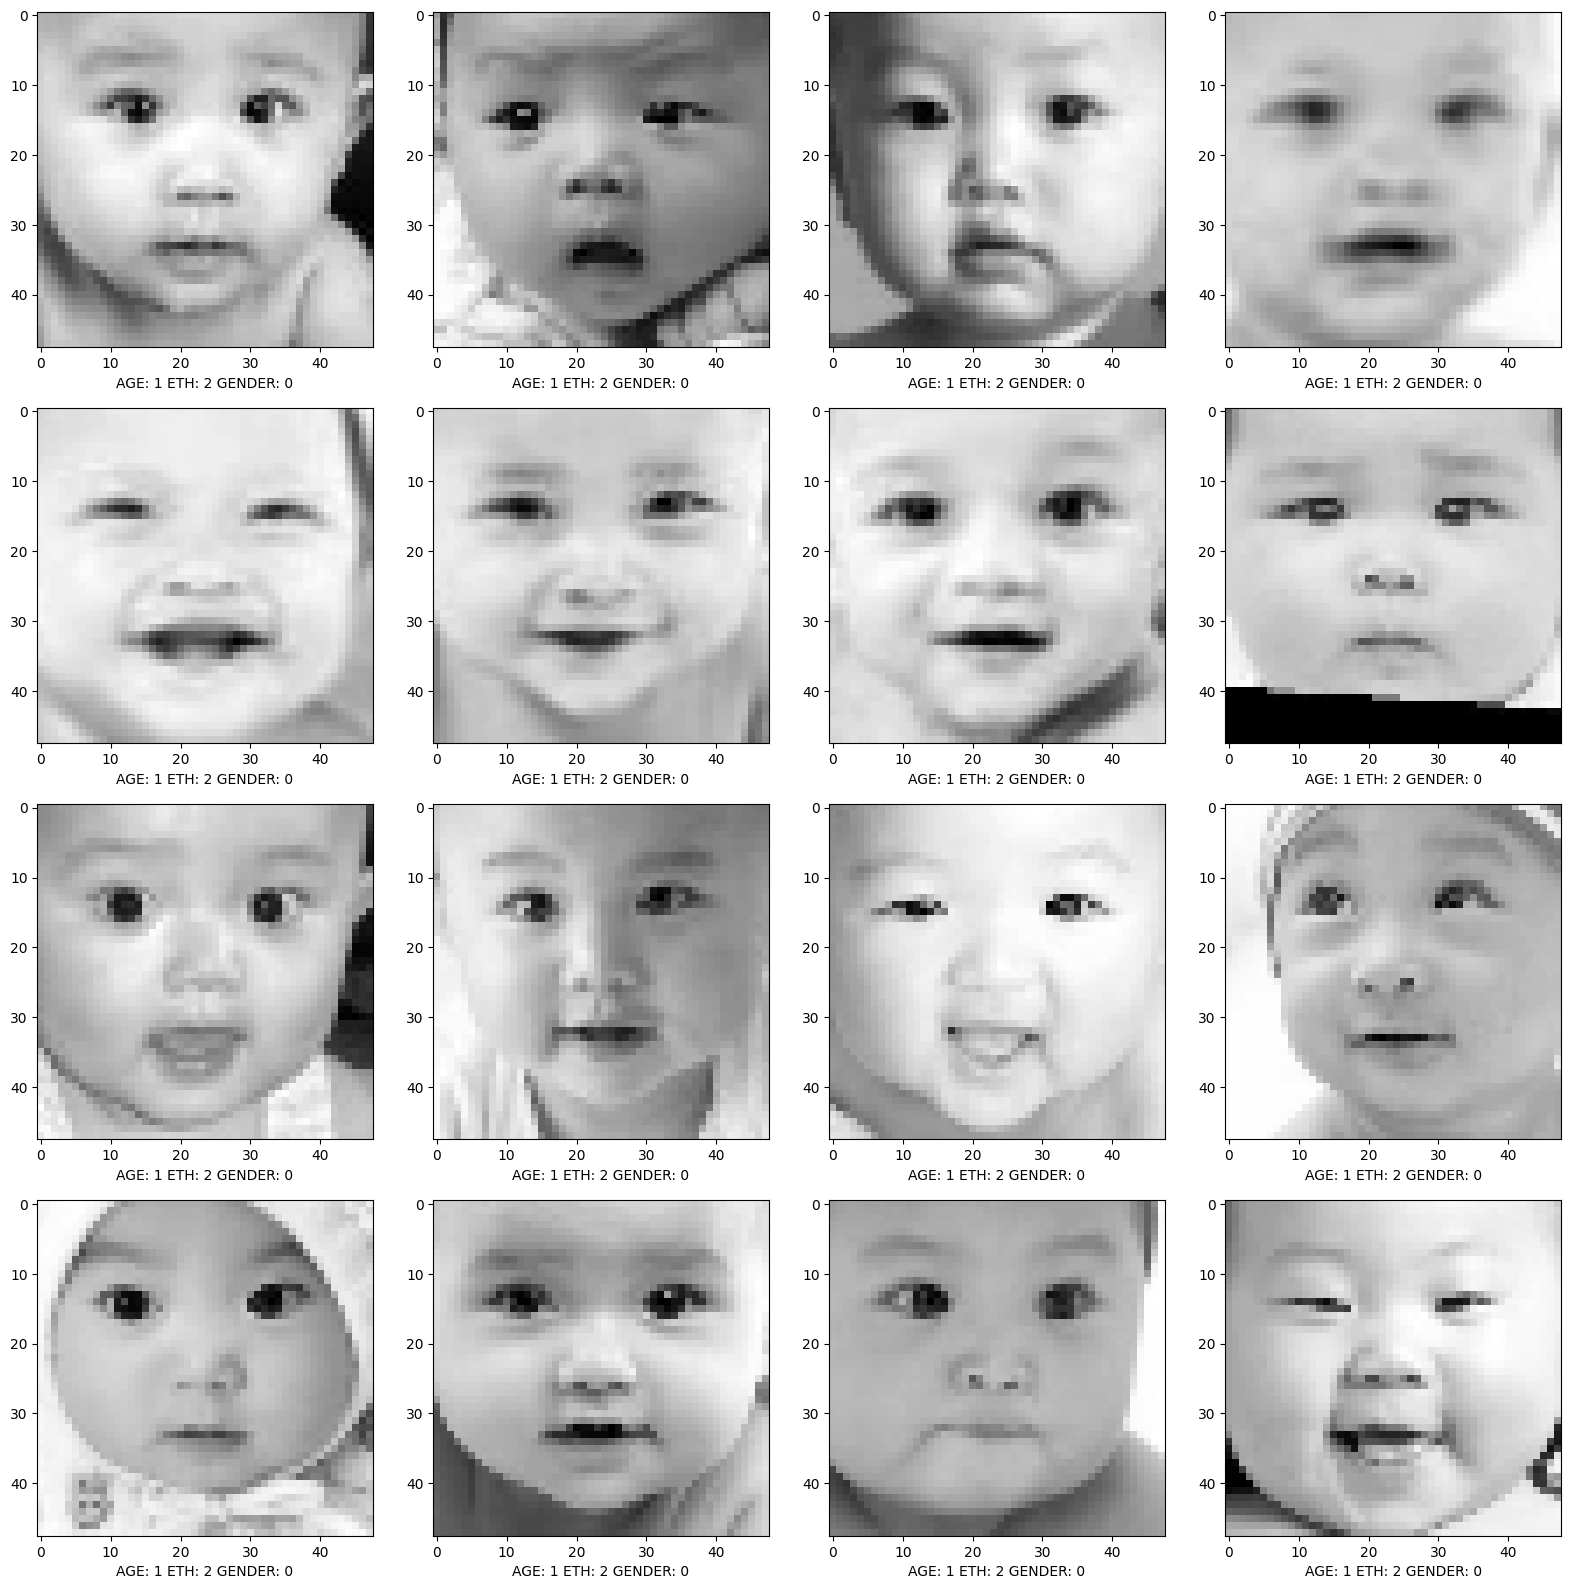

In [19]:
figure,axis = plt.subplots(4,4,figsize=(16,16))

for indexing,operations in enumerate(axis.flat):
    Picking_Image = X[indexing]
    
    operations.set_xlabel(f"AGE: {str(data.age.iloc[indexing])} "+f"ETH: {str(data.ethnicity.iloc[indexing])} "+f"GENDER: {str(data.gender.iloc[indexing])}")
    operations.imshow(Picking_Image, cmap='gray')
    
plt.tight_layout()
plt.show()

semua data pixels sudah terkonversi dalam bentuk (48,48,1)

## Split Data

 ### Feature Gender

In [20]:
def split_and_reshape(X, y, test_size=0.22, random_state=37, stratify=None):
    X1 = np.array(X['pixels'].tolist())
    X_reshaped = X1.reshape(X1.shape[0], 48, 48, 1)

    X_train, X_test, y_train, y_test = train_test_split(
        X_reshaped, y, test_size=test_size, random_state=random_state, stratify=stratify
    )

    # Mencetak bentuk (shape) dari setiap data
    print_shapes(X_train, X_test, y_train, y_test)

    return X_train, X_test, y_train, y_test

def print_shapes(X_train, X_test, y_train, y_test):
    for data in [X_train, X_test, y_train, y_test]:
        print(data.shape)

In [21]:
X_train1, X_test1, y_train1, y_test1 = split_and_reshape(data, data['gender'])

(18489, 48, 48, 1)
(5216, 48, 48, 1)
(18489,)
(5216,)


membagi data pixel dan label gender menjadi set pelatihan dan pengujian. Set pengujian sebesar 22% dari total data, dengan pengaturan untuk menjaga proporsi kelas gender yang seimbang antara set pelatihan dan pengujian.

In [22]:
def print_target_distribution(y_train, y_test, index):
    for i, value in enumerate([y_train, y_test]):
        dataset_type = 'train' if i == 0 else 'test'
        print(f'distribusi target y_{dataset_type}{index}')
        print(value.value_counts())
        print('-'*10)

In [23]:
print_target_distribution(y_train1, y_test1,1)

distribusi target y_train1
gender
0    9695
1    8794
Name: count, dtype: int64
----------
distribusi target y_test1
gender
0    2696
1    2520
Name: count, dtype: int64
----------


Dataset gender terdiri dari dua kelas, dengan jumlah sampel yang cukup seimbang antara kelas 0 dan kelas 1 pada data pelatihan dan data uji.

### Features Ethnicity

In [24]:
def merge_dataframes_by_value(df, target_column, value):
    jumlah_value = df[target_column].value_counts().loc[value]

    # Mengambil baris dengan nilai target_column sama dengan nilai tertentu sebanyak jumlah_value
    df_value = df[df[target_column] == value].head(jumlah_value)

    # Mengambil baris dengan nilai target_column tidak sama dengan nilai tertentu sebanyak jumlah_value untuk setiap nilai unik
    unique_values = df[target_column].unique()
    df_others = pd.concat([df[df[target_column] == val].head(jumlah_value) for val in unique_values if val != value])

    # Menggabungkan DataFrame yang memiliki nilai target_column sama dengan nilai tertentu dan tidak sama dengan nilai tertentu
    merged_df = pd.concat([df_value, df_others]).reset_index(drop=True)

    return merged_df

In [25]:
ethnicity_df = data.copy()
ethnicity_df = merge_dataframes_by_value(ethnicity_df, 'ethnicity', 4)

membuat DataFrame baru ethnicity_df dengan menyeimbangkan jumlah baris antara nilai ethnicity 4 dan nilai ethnicity 0, 1, 2, serta 3, sehingga setiap nilai ethnicity memiliki jumlah baris yang sama.

In [26]:
X_train2, X_test2, y_train2, y_test2 = split_and_reshape(ethnicity_df, ethnicity_df['ethnicity'])

(6598, 48, 48, 1)
(1862, 48, 48, 1)
(6598,)
(1862,)


Data pixel dari ethnicity_df diubah dari representasi 1D menjadi 3D, dan kemudian dibagi menjadi set pelatihan dan pengujian bersama dengan label ethnicity untuk pengujian model.

In [27]:
print_target_distribution(y_train2, y_test2, 2)

distribusi target y_train2
ethnicity
1    1325
4    1324
3    1321
2    1316
0    1312
Name: count, dtype: int64
----------
distribusi target y_test2
ethnicity
0    380
2    376
3    371
4    368
1    367
Name: count, dtype: int64
----------


Dataset etnis memiliki distribusi yang relatif seimbang di antara kelasnya, baik pada data pelatihan maupun data uji. 

### Features Age

In [28]:
age_df = data.copy()
age_df = merge_dataframes_by_value(age_df, 'age_', 2)

membuat DataFrame baru age_df dengan menyeimbangkan jumlah baris antara nilai ethnicity 2 dan nilai ethnicity 0, 1, 3, serta 4, sehingga setiap nilai age_category memiliki jumlah baris yang sama.

In [29]:
X_train3, X_test3, y_train3, y_test3 = split_and_reshape(age_df, age_df['age_'])

(4219, 48, 48, 1)
(1191, 48, 48, 1)
(4219,)
(1191,)


Data pixel dari age_df diubah dari representasi 1D menjadi 3D, dan kemudian dibagi menjadi set pelatihan dan pengujian bersama dengan label age_category untuk pengujian model.

In [30]:
print_target_distribution(y_train3, y_test3, 3)

distribusi target y_train3
age_
1    858
2    850
0    842
3    835
4    834
Name: count, dtype: int64
----------
distribusi target y_test3
age_
4    248
3    247
0    240
2    232
1    224
Name: count, dtype: int64
----------


Dataset age memiliki distribusi yang relatif seimbang di antara kelasnya, baik pada data pelatihan maupun data uji. 

## Augmentation

### for Features Gender

In [31]:
def create_data_generator(X_train, y_train):
    imgen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=120,
        zoom_range=[0.3, 1.5],
        validation_split=0.25)
    train_generator = imgen.flow(
        X_train,
        y_train,
        subset='training',
        shuffle=False)
    val_generator = imgen.flow(
        X_train,
        y_train,
        subset='validation',
        shuffle=False)
    return train_generator, val_generator

def plot_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    for i in range(num_images):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title('Label: ' + str(labels[i]))
        axes[i].axis('off')

    plt.show()

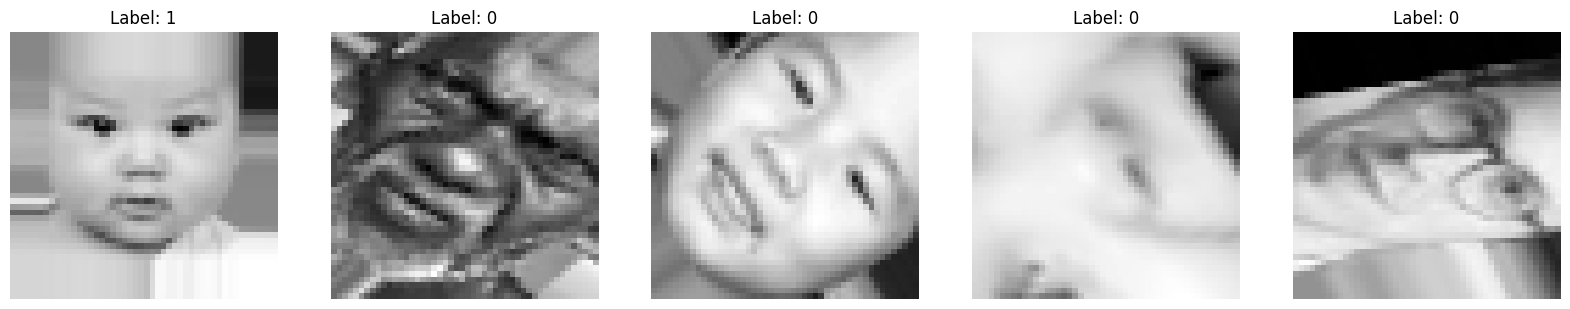

In [32]:
train1, val1 = create_data_generator(X_train1, y_train1)
images, labels = train1.next()
plot_images(images, labels)

Pemilihan rotasi maksimum 120 derajat dan rentang zoom 0.3 hingga 1.5 didasarkan pada keinginan untuk memberikan variasi yang signifikan, sesuai dengan kebutuhan pengenalan gambar, sambil tetap menjaga efisiensi pelatihan dan mencegah overfitting. Variasi tersebut dianggap cukup efektif untuk meningkatkan kemampuan model tanpa memperkenalkan kompleksitas yang berlebihan. 

### for Features Ethnicity

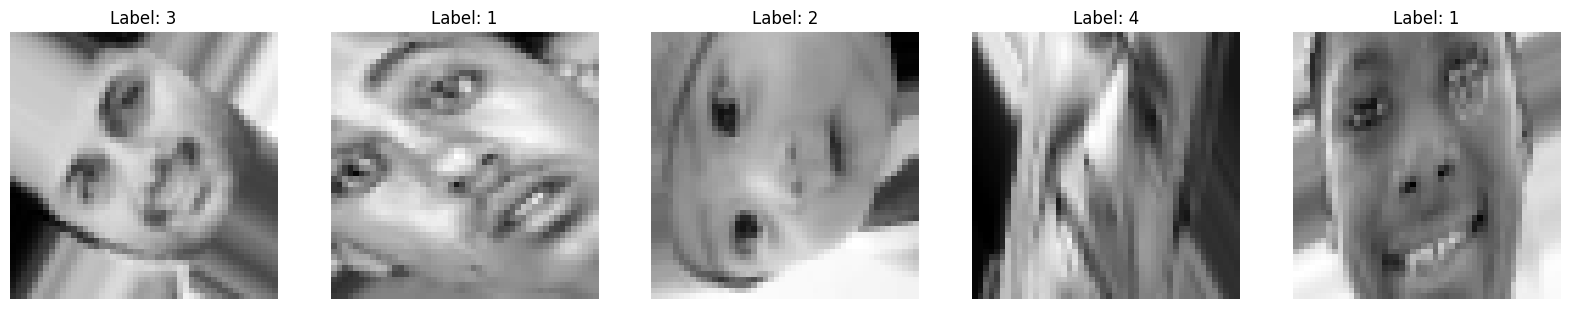

In [33]:
train2, val2 = create_data_generator(X_train2, y_train2)
images2, labels2 = train2.next()
plot_images(images2, labels2)

### for Features Age

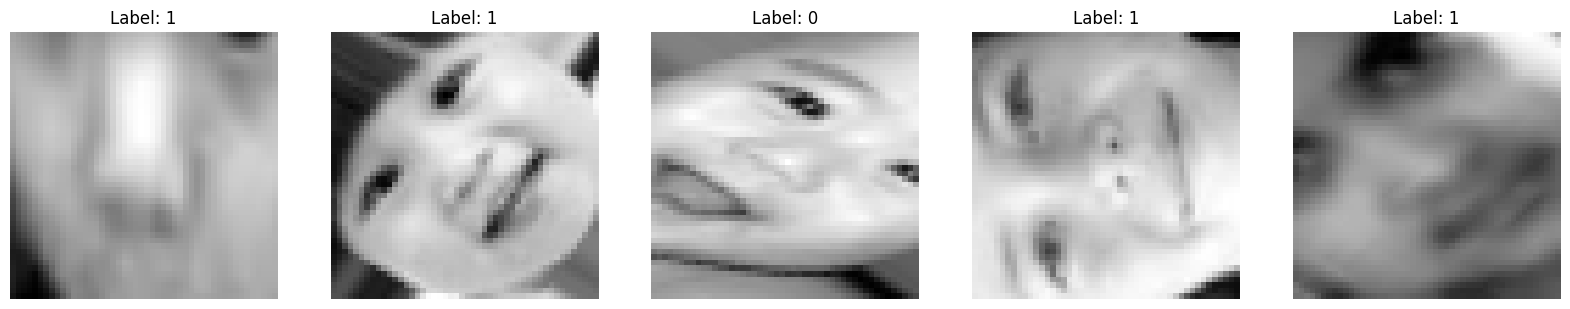

In [34]:
train3, val3 = create_data_generator(X_train3, y_train3)
images3, labels3 = train3.next()
plot_images(images3, labels3)

# Model Definition

## Architecture for Gender

### Base Model 

Menggunakan base model Convolutional Neural Network (CNN) adalah untuk memberikan model kemampuan untuk secara mandiri mengekstrak fitur-fitur penting dari data gambar wajah pada tugas prediksi age, gender, dan etnis. Dengan memulai dari awal, model CNN dapat lebih spesifik terhadap dataset yang digunakan, meskipun ini dapat mengakibatkan waktu pelatihan yang lebih lama karena perlu mempelajari representasi fitur secara menyeluruh.

In [35]:
model_gender = Sequential()

model_gender.add(Conv2D(32,(3,3),activation='relu',input_shape=(48,48,1)))
model_gender.add(MaxPooling2D(2,2))

model_gender.add(Conv2D(64,(3,3),activation='relu'))
model_gender.add(MaxPooling2D(2,2))

model_gender.add(Conv2D(64,(3,3),activation='relu'))
model_gender.add(MaxPooling2D(2,2))

model_gender.add(Flatten())
model_gender.add(Dense(1,activation='sigmoid'))

model_gender.compile(optimizer='SGD' ,loss='BinaryCrossentropy',metrics=['accuracy'])

model_gender.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 64)        

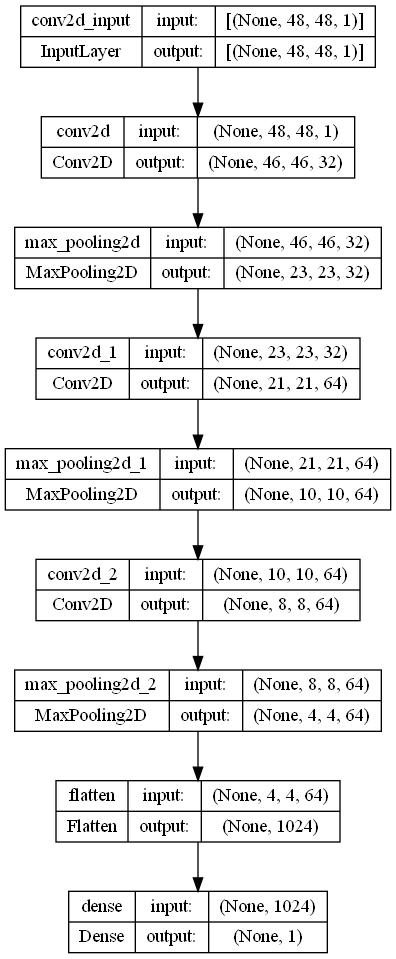

In [36]:
tf.keras.utils.plot_model(model_gender, show_shapes=True)

Saya memilih struktur model ini dengan tiga lapisan konvolusi yang menggunakan 32, 64, dan 64 filter berturut-turut, diikuti oleh lapisan MaxPooling. Lapisan Flatten digunakan untuk menyusun hasil dari lapisan konvolusi ke dalam vektor, dan lapisan Dense dengan satu neuron dan fungsi aktivasi sigmoid bertanggung jawab untuk menghasilkan output klasifikasi gender (0 atau 1). 

Keseluruhan, model ini memanfaatkan 161 neuron untuk mengekstraksi dan mengolah fitur dari gambar wajah. Pemilihan struktur ini didasarkan pada keinginan untuk memungkinkan model memahami pola-pola yang kompleks pada gambar wajah, memastikan kinerja yang baik dalam tugas klasifikasi gender.

### Improve Model

Untuk meningkatkan performa model CNN, terutama dalam hal waktu pelatihan dan akurasi, penerapan transfer learning dengan menggunakan model MobileNetV2 dapat menjadi pilihan yang bijak. Transfer learning memanfaatkan pengetahuan yang telah diperoleh oleh model dari dataset yang lebih besar sebelumnya. MobileNetV2, dengan arsitektur yang ringan dan efisien, dapat membantu mempercepat pelatihan sambil tetap memberikan representasi fitur yang kuat untuk tugas prediksi age, gender, dan etnis pada dataset tertentu. Dengan demikian, penggunaan transfer learning dengan MobileNetV2 dapat menjadi strategi efektif untuk meningkatkan kinerja model CNN pada tugas-tugas visual yang kompleks.

In [37]:
# Membuat model dengan transfer learning menggunakan MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Menambahkan lapisan Lambda untuk konversi warna menjadi tiga saluran (RGB)
model_gender_transfer = Sequential()
model_gender_transfer.add(Lambda(lambda x: tf.image.grayscale_to_rgb(x), input_shape=(48, 48, 1)))
model_gender_transfer.add(base_model)
model_gender_transfer.add(GlobalAveragePooling2D())
model_gender_transfer.add(Dense(256, activation='relu'))
model_gender_transfer.add(Dropout(0.5))
model_gender_transfer.add(Dense(64, activation='relu'))
model_gender_transfer.add(Dense(1, activation='sigmoid'))

# Fine-tuning beberapa lapisan dasar
base_model.trainable = True
fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Menggunakan optimizer SGD dengan learning rate yang lebih rendah
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model_gender_transfer.compile(optimizer=optimizer, loss='BinaryCrossentropy', metrics=['accuracy'])

model_gender_transfer.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 48, 48, 3)         0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_1 (Dense)             (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)               

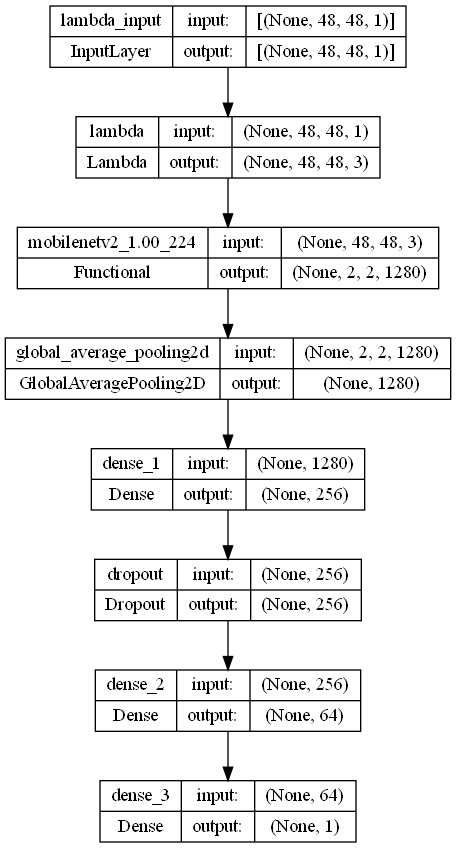

In [38]:
tf.keras.utils.plot_model(model_gender_transfer, show_shapes=True)

Saya pilih transfer learning dengan MobileNetV2 karena telah dilatih pada imagenet, berharap meningkatkan kinerja model pada klasifikasi gender wajah. MobileNetV2 dipilih karena ringan, sesuai untuk ukuran gambar wajah kecil (48x48 piksel). GlobalAveragePooling2D digunakan untuk ekstraksi fitur yang sederhana sesuai tujuan tugas.

Lapisan-lapisan Dense dengan relu dan Dropout ditambahkan untuk meningkatkan kemampuan model dalam mengekstraksi pola relevan pada gambar wajah. Fine-tuning dilakukan pada beberapa lapisan dasar MobileNetV2 agar model sesuai dengan konteks tugas klasifikasi gender pada gambar wajah.

Pemilihan dan fine-tuning ini dilakukan untuk mencapai keseimbangan antara kinerja model yang baik dan efisiensi komputasi dalam tugas tersebut.

## Architecture for Ethnicity

 ### Base Model 

In [39]:
model_ethnicity = Sequential()

model_ethnicity.add(Conv2D(16,(3,3), padding='same',activation='relu',input_shape=(48,48,1)))
model_ethnicity.add(MaxPooling2D(2,2))

model_ethnicity.add(Conv2D(32,(3,3), padding='same',activation='relu'))
model_ethnicity.add(MaxPooling2D(2,2))

model_ethnicity.add(Conv2D(64,(3,3), padding='same',activation='relu'))
model_ethnicity.add(MaxPooling2D(2,2))


model_ethnicity.add(Flatten())
model_ethnicity.add(Dense(128,activation='relu'))
model_ethnicity.add(Dense(5,activation='softmax'))

model_ethnicity.compile(optimizer='adam' ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model_ethnicity.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 64)         

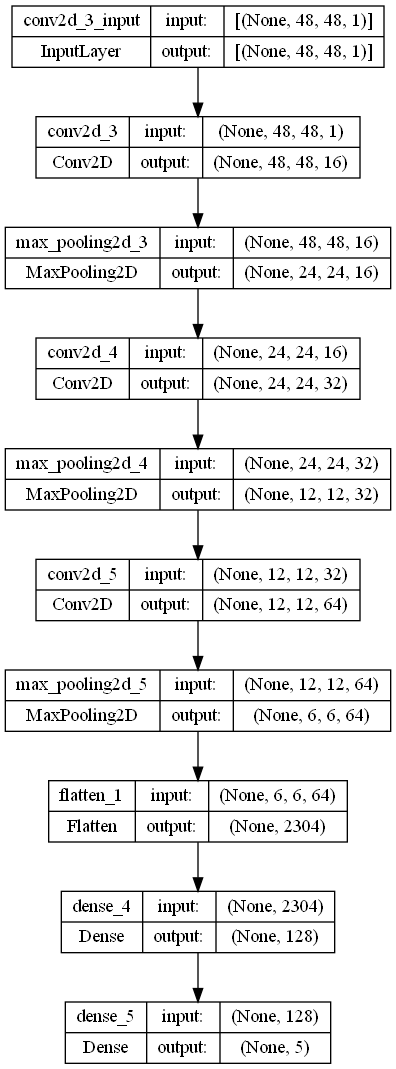

In [40]:
tf.keras.utils.plot_model(model_ethnicity, show_shapes=True)

Saya rancang model CNN untuk klasifikasi etnis berukuran gambar wajah 48x48 piksel. Dimulai dengan lapisan konvolusi pertama (16 filter), dilanjutkan dengan lapisan MaxPooling untuk mereduksi dimensi gambar. Dua lapisan konvolusi tambahan (32 dan 64 filter) diikuti oleh lapisan MaxPooling membantu model mengekstraksi fitur-fitur kompleks.

Hasil dari lapisan konvolusi di-flatten menjadi vektor satu dimensi, lalu melewati dua lapisan Dense. Lapisan pertama (128 neuron, ReLU) dan lapisan terakhir (5 neuron, softmax) menghasilkan distribusi probabilitas etnis.

Model ini di-compile dengan optimizer Adam, loss function sparse categorical crossentropy (karena banyak kelas), dan metrik akurasi. Ringkasannya memberikan gambaran mengenai struktur dan parameter-model untuk tugas klasifikasi etnis pada gambar wajah.

### Improve Model

In [41]:
# Menambahkan lapisan Lambda untuk konversi warna menjadi tiga saluran (RGB)
model_ethnicity_transfer = Sequential()
model_ethnicity_transfer.add(Lambda(lambda x: tf.image.grayscale_to_rgb(x), input_shape=(48, 48, 1)))
model_ethnicity_transfer.add(base_model)
model_ethnicity_transfer.add(GlobalAveragePooling2D())
model_ethnicity_transfer.add(Dense(256, activation='relu'))
model_ethnicity_transfer.add(Dropout(0.5))
model_ethnicity_transfer.add(Dense(64, activation='relu'))
model_ethnicity_transfer.add(Dense(5, activation='softmax'))

# Fine-tuning beberapa lapisan dasar
base_model.trainable = True
fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Menggunakan optimizer SGD dengan learning rate yang lebih rendah
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model_ethnicity_transfer.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_ethnicity_transfer.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 48, 48, 3)         0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 64)               

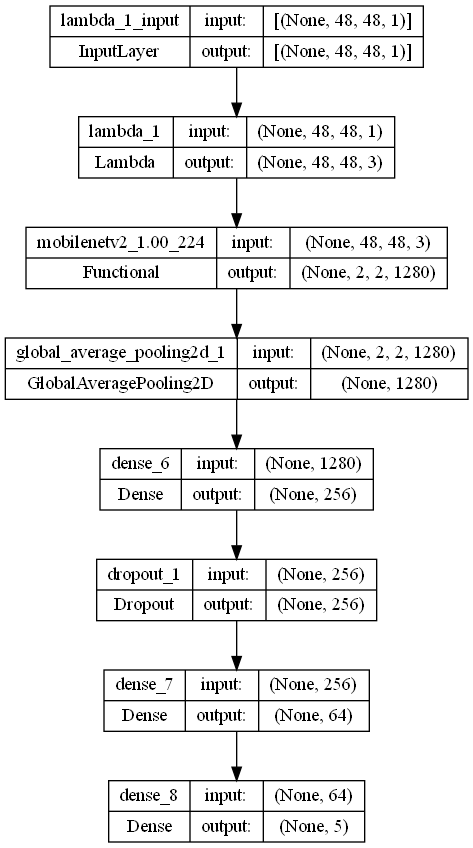

In [42]:
tf.keras.utils.plot_model(model_ethnicity_transfer, show_shapes=True)

Saya susun model klasifikasi etnis dengan transfer learning menggunakan MobileNetV2. Dimulai dengan lapisan Lambda untuk mengonversi gambar grayscale menjadi tiga saluran (RGB). Lalu, terdapat lapisan MobileNetV2, GlobalAveragePooling2D, dan beberapa lapisan Dense (256 neuron, relu, 64 neuron, relu, dan 5 neuron, softmax).

Beberapa lapisan dasar MobileNetV2 di-fine-tune agar sesuai dengan tugas klasifikasi etnis. Model di-compile menggunakan SGD dengan learning rate rendah (0.001), momentum 0.9, dan loss function sparse categorical crossentropy (karena banyak kelas). Summary model memberikan gambaran struktur dan parameter-parameter yang digunakan dalam model klasifikasi etnis transfer learning ini.

## Architecture for Age

### Base Model

In [43]:
model_age = Sequential()

model_age.add(Conv2D(16,(3,3), padding='same',activation='relu',input_shape=(48,48,1)))
model_age.add(MaxPooling2D(2,2))

model_age.add(Conv2D(32,(3,3), padding='same',activation='relu'))
model_age.add(MaxPooling2D(2,2))

model_age.add(Conv2D(64,(3,3), padding='same',activation='relu'))
model_age.add(MaxPooling2D(2,2))


model_age.add(Flatten())
model_age.add(Dense(128,activation='relu'))


model_age.add(Dense(5,activation='softmax'))

model_age.compile(optimizer='adam' ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model_age.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 24, 24, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 6, 6, 64)         

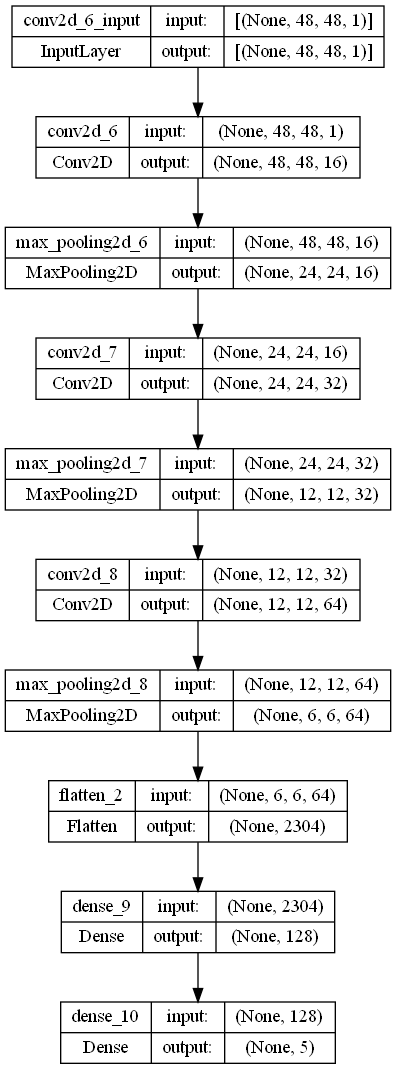

In [44]:
tf.keras.utils.plot_model(model_age, show_shapes=True)

Saya desain model klasifikasi usia menggunakan CNN dengan tiga lapisan konvolusi dan MaxPooling untuk mereduksi dimensi. Struktur ini dipilih untuk ekstraksi fitur yang kompleks. Hasilnya di-flatten dan melewati lapisan Dense (128 neuron, ReLU).

Output akhir adalah Dense dengan 5 neuron dan softmax untuk distribusi probabilitas usia. Model di-compile dengan optimizer Adam, loss function sparse categorical crossentropy, dan metrik akurasi. Pemilihan arsitektur dan konfigurasi ini bertujuan memberikan performa optimal dalam klasifikasi usia pada gambar wajah.

### Improve Model

In [45]:
# Menambahkan lapisan Lambda untuk konversi warna menjadi tiga saluran (RGB)
model_age_transfer = Sequential()
model_age_transfer.add(Lambda(lambda x: tf.image.grayscale_to_rgb(x), input_shape=(48, 48, 1)))
model_age_transfer.add(base_model)
model_age_transfer.add(GlobalAveragePooling2D())
model_age_transfer.add(Dense(256, activation='relu'))
model_age_transfer.add(Dropout(0.5))
model_age_transfer.add(Dense(64, activation='relu'))
model_age_transfer.add(Dense(5, activation='softmax'))

# Fine-tuning beberapa lapisan dasar
base_model.trainable = True
fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Menggunakan optimizer SGD dengan learning rate yang lebih rendah
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model_age_transfer.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_age_transfer.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 48, 48, 3)         0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_11 (Dense)            (None, 256)               327936    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 64)               

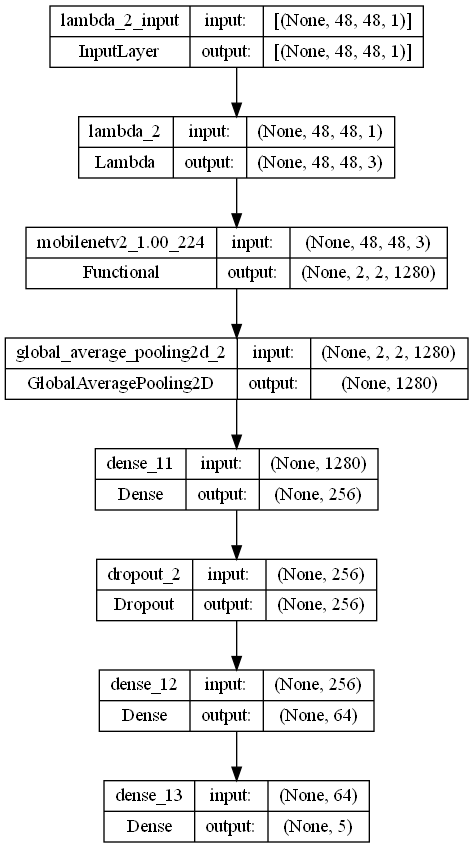

In [46]:
tf.keras.utils.plot_model(model_age_transfer, show_shapes=True)

Saya desain model klasifikasi usia dengan transfer learning menggunakan MobileNetV2. Pemilihan arsitektur ini melibatkan lapisan Lambda untuk mengonversi gambar ke tiga saluran RGB, dilanjutkan dengan lapisan MobileNetV2, GlobalAveragePooling2D, dan beberapa lapisan Dense (256 neuron, relu, 64 neuron, relu, dan 5 neuron, softmax).

Arsitektur ini dipilih untuk memanfaatkan pengetahuan yang sudah ada dari MobileNetV2 dalam mengenali berbagai pola visual. Beberapa lapisan MobileNetV2 di-fine-tune untuk penyesuaian dengan tugas klasifikasi usia. Model di-compile menggunakan SGD dengan learning rate rendah (0.001), momentum 0.9, dan loss function sparse categorical crossentropy (karena banyak kelas).

Dengan konfigurasi ini, diharapkan model dapat memberikan performa yang baik dalam mengklasifikasikan usia pada gambar wajah.

# Model Training

## Training for Gender

### Base Model 

In [47]:
# Melatih model dengan augmentasi data lebih lanjut dan early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

Membuat early stopping untuk penerapan callback, teknik yang digunakan untuk menghentikan proses pelatihan model jika tidak terjadi perbaikan yang signifikan dalam metrik tertentu, dalam hal ini metrik yang dipantau adalah 'val_loss' (loss pada data validasi). 

Jika tidak terjadi perbaikan dalam 'patience' epoch berturut-turut, pelatihan akan dihentikan, dan model akan dikembalikan ke bobot terbaiknya.

In [48]:
history_gender = model_gender.fit(
    train1, 
    epochs=50,  
    validation_data=val1, 
    batch_size=64, 
    callbacks=[early_stopping]
)

Epoch 1/50




434/434 [==============================] - 13s 29ms/step - loss: 0.6904 - accuracy: 0.5417 - val_loss: 0.6883 - val_accuracy: 0.6045
Epoch 2/50
434/434 [==============================] - 11s 25ms/step - loss: 0.6856 - accuracy: 0.5873 - val_loss: 0.6827 - val_accuracy: 0.5872
Epoch 3/50
434/434 [==============================] - 11s 25ms/step - loss: 0.6780 - accuracy: 0.5972 - val_loss: 0.6709 - val_accuracy: 0.6302
Epoch 4/50
434/434 [==============================] - 11s 25ms/step - loss: 0.6668 - accuracy: 0.6087 - val_loss: 0.6582 - val_accuracy: 0.6298
Epoch 5/50
434/434 [==============================] - 11s 25ms/step - loss: 0.6533 - accuracy: 0.6218 - val_loss: 0.6666 - val_accuracy: 0.5865
Epoch 6/50
434/434 [==============================] - 11s 25ms/step - loss: 0.6452 - accuracy: 0.6262 - val_loss: 0.6373 - val_accuracy: 0.6454
Epoch 7/50
434/434 [==============================] - 11s 25ms/step - loss: 0.6410 - accuracy: 0.6297 - val_loss: 0.6468 - val_accuracy: 0.6222
Ep

melakukan pelatihan model gender (menggunakan neural network) dengan data pelatihan (train1) selama 50 epoch. Proses pelatihan juga melibatkan data validasi (val1) untuk memonitor performa model pada dataset yang tidak digunakan selama pelatihan utama. Batch size sebesar 64 digunakan, yang berarti model akan diperbarui setiap 64 sampel. Callback early stopping juga diterapkan untuk memantau loss pada data validasi dan menghentikan pelatihan jika tidak terjadi perbaikan dalam 10 epoch berturut-turut.

In [49]:
def plot_training_history(history, title_prefix):
    sns.set(style="whitegrid")
    
    # Membuat subplot dengan 2 kolom
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plotting Loss dan Accuracy
    for ax, metric, ylabel in zip(axes, ['loss', 'accuracy'], ['Loss', 'Accuracy']):
        sns.lineplot(data=history.history[metric], label=f'Training {ylabel}', ax=ax)
        sns.lineplot(data=history.history[f'val_{metric}'], label=f'Validation {ylabel}', ax=ax)
        ax.set(xlabel='Epoch', ylabel=f'{ylabel} {title_prefix}')
        ax.set_title(f'Training and Validation {ylabel} {title_prefix}')
        ax.legend()

    # Menampilkan plot
    plt.show()

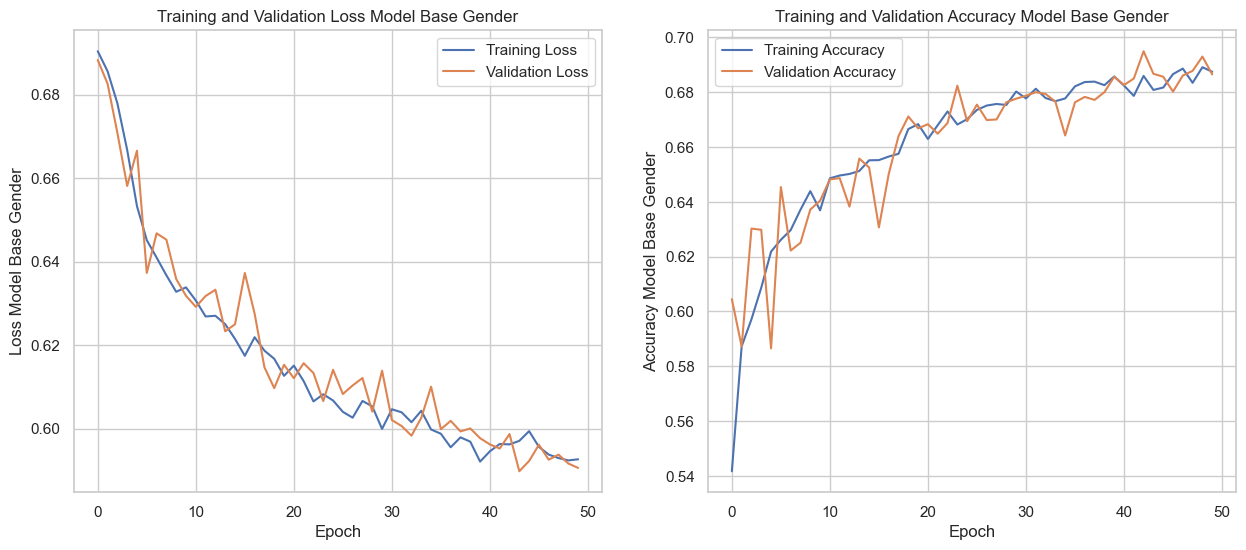

In [50]:
plot_training_history(history_gender, 'Model Base Gender')

Model ini tampaknya mengalami beberapa fluktuasi dalam akurasi selama pelatihan. Pada awalnya, terdapat peningkatan yang positif, tetapi kemudian terjadi variasi yang signifikan. Hal ini menunjukkan bahwa model mungkin belum sepenuhnya stabil atau belum mengatasi semua aspek kompleksitas dataset.

### Improve Model

In [51]:
history_gender_transfer = model_gender_transfer.fit(
    train1, 
    epochs=50,  
    validation_data=val1, 
    batch_size=64, 
    callbacks=[early_stopping]
)


Epoch 1/50


434/434 [==============================] - 49s 102ms/step - loss: 0.6981 - accuracy: 0.5802 - val_loss: 0.7241 - val_accuracy: 0.5383
Epoch 2/50
434/434 [==============================] - 46s 105ms/step - loss: 0.6225 - accuracy: 0.6541 - val_loss: 0.6580 - val_accuracy: 0.6069
Epoch 3/50
434/434 [==============================] - 46s 105ms/step - loss: 0.5915 - accuracy: 0.6839 - val_loss: 0.6161 - val_accuracy: 0.6608
Epoch 4/50
434/434 [==============================] - 45s 103ms/step - loss: 0.5695 - accuracy: 0.7074 - val_loss: 0.5859 - val_accuracy: 0.6891
Epoch 5/50
434/434 [==============================] - 45s 104ms/step - loss: 0.5500 - accuracy: 0.7227 - val_loss: 0.5410 - val_accuracy: 0.7352
Epoch 6/50
434/434 [==============================] - 45s 103ms/step - loss: 0.5324 - accuracy: 0.7296 - val_loss: 0.5262 - val_accuracy: 0.7419
Epoch 7/50
434/434 [==============================] - 45s 104ms/step - loss: 0.5213 - accuracy: 0.7426 - val_loss: 0.5246 - val_accuracy: 0.7

Mirip dengan yang sebelumnya, tetapi model yang digunakan mungkin berbeda, seperti model yang telah melalui proses transfer learning. Model gender transfer dilatih dengan data pelatihan (train1) selama 50 epoch dengan menggunakan data validasi (val1) untuk memonitor kinerja model. Batch size sebesar 64 digunakan, dan callback early stopping diterapkan untuk menghentikan pelatihan jika tidak terjadi perbaikan dalam 10 epoch berturut-turut. Proses ini memberikan model kesempatan untuk belajar dari data pelatihan dan memperbaiki diri melalui iterasi berulang.

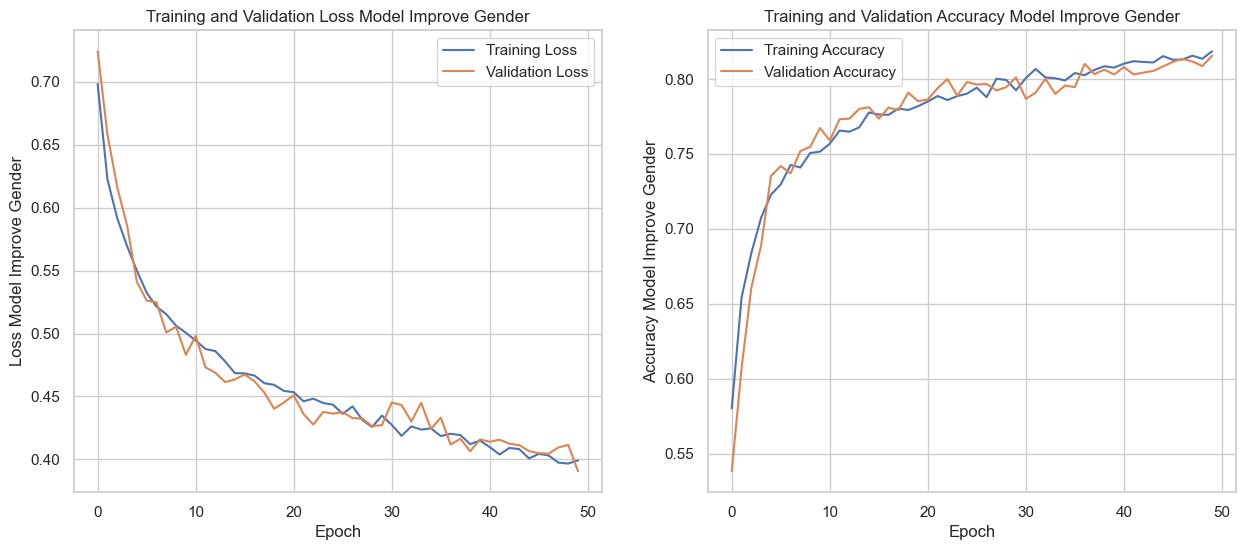

In [52]:
plot_training_history(history_gender_transfer, 'Model Improve Gender')

Model transfer learning ini menunjukkan peningkatan kinerja yang stabil selama pelatihan. Dari awal hingga akhir, akurasi pada data pelatihan dan validasi terus meningkat, menunjukkan bahwa model dapat dengan baik mengekstraksi fitur-fitur yang relevan dari dataset. Epoch awal menunjukkan akurasi rendah pada data pelatihan dan validasi, tetapi seiring berjalannya waktu, model dapat mempelajari pola yang lebih kompleks dan meningkatkan performanya.

### Base & Improve Comparison for Gender Model

|model|loss| acc | val_loss| val_acc| time |
| --- | --- |---|---|---|---|
|model_gender | 0.5927 | 0.6875 | 0.5906 | 0.6865 |10m 10.7s|
|model_gender_transfer| 0.3992 | 0.8184 | 0.3906 | 0.8154 |28m 28.9s|


Dilihat dari hasil yang diberikan, "model_gender_transfer" menunjukkan performa yang jauh lebih baik dibandingkan dengan "model_gender." Meskipun waktu pelatihan lebih lama, peningkatan signifikan dalam akurasi pada kedua data pelatihan dan validasi membuat "model_gender_transfer" menjadi pilihan yang lebih baik. Oleh karena itu, saya menggunakan "model_gender_transfer" untuk keperluan selanjutnya.

## Training for Ethnicity

### Base Model

In [53]:
history_ethnicity = model_ethnicity.fit(
    train2, 
    epochs=50,  
    validation_data=val2, 
    batch_size=64, 
    callbacks=[early_stopping]
)

Epoch 1/50


155/155 [==============================] - 3s 17ms/step - loss: 1.5511 - accuracy: 0.2799 - val_loss: 1.5935 - val_accuracy: 0.2759
Epoch 2/50
155/155 [==============================] - 3s 17ms/step - loss: 1.4869 - accuracy: 0.3308 - val_loss: 1.5093 - val_accuracy: 0.3014
Epoch 3/50
155/155 [==============================] - 3s 16ms/step - loss: 1.4797 - accuracy: 0.3324 - val_loss: 1.5107 - val_accuracy: 0.3214
Epoch 4/50
155/155 [==============================] - 2s 16ms/step - loss: 1.4761 - accuracy: 0.3383 - val_loss: 1.4793 - val_accuracy: 0.3269
Epoch 5/50
155/155 [==============================] - 3s 16ms/step - loss: 1.4611 - accuracy: 0.3461 - val_loss: 1.5084 - val_accuracy: 0.3184
Epoch 6/50
155/155 [==============================] - 2s 16ms/step - loss: 1.4482 - accuracy: 0.3536 - val_loss: 1.4587 - val_accuracy: 0.3378
Epoch 7/50
155/155 [==============================] - 2s 16ms/step - loss: 1.4375 - accuracy: 0.3641 - val_loss: 1.4403 - val_accuracy: 0.3578
Epoch 8/50

Melakukan pelatihan model ethnicity. Model tersebut dilatih dengan menggunakan data pelatihan (train2) selama 50 epoch, dengan data validasi (val2) digunakan untuk memantau kinerja model selama pelatihan. Batch size sebesar 64 digunakan, dan callback early stopping diimplementasikan untuk menghentikan pelatihan jika tidak ada peningkatan yang signifikan dalam nilai val_loss selama 10 epoch berturut-turut. Proses pelatihan ini bertujuan untuk mengoptimalkan model agar dapat mengklasifikasikan etnisitas dengan akurasi yang baik.

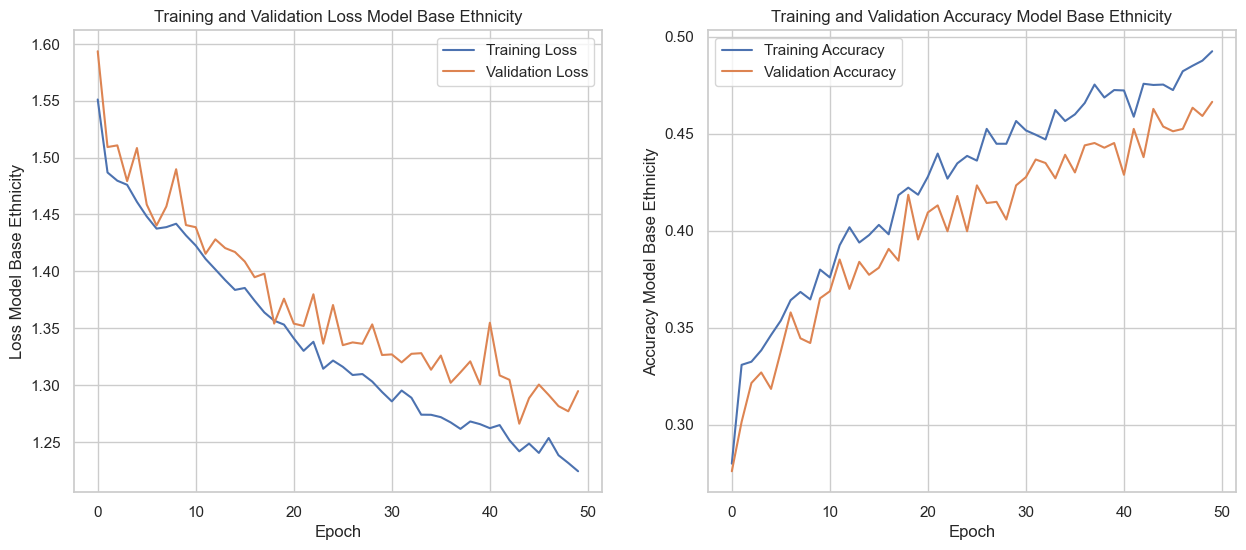

In [54]:
plot_training_history(history_ethnicity, 'Model Base Ethnicity')

selama pelatihan. Meskipun ada fluktuasi dalam akurasi dan loss pada beberapa epoch, secara umum, model ini cenderung menghasilkan akurasi yang konsisten pada data pelatihan dan validasi.

Epoch awal menunjukkan akurasi yang baik, tetapi ada beberapa fluktuasi di tengah pelatihan. Pada akhirnya, model mencapai akurasi yang cukup baik pada data pelatihan dan validasi.

### Improve Model

In [55]:
history_ethnicity_transfer = model_ethnicity_transfer.fit(
    train2, 
    epochs=50,
    validation_data=val2, 
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/50
155/155 [==============================] - 16s 82ms/step - loss: 1.6546 - accuracy: 0.2584 - val_loss: 1.5299 - val_accuracy: 0.3105
Epoch 2/50
155/155 [==============================] - 12s 76ms/step - loss: 1.5154 - accuracy: 0.3324 - val_loss: 1.4878 - val_accuracy: 0.3420
Epoch 3/50
155/155 [==============================] - 12s 78ms/step - loss: 1.4512 - accuracy: 0.3734 - val_loss: 1.4423 - val_accuracy: 0.3681
Epoch 4/50
155/155 [==============================] - 11s 74ms/step - loss: 1.4136 - accuracy: 0.3880 - val_loss: 1.4325 - val_accuracy: 0.3845
Epoch 5/50
155/155 [==============================] - 11s 73ms/step - loss: 1.3824 - accuracy: 0.4122 - val_loss: 1.3813 - val_accuracy: 0.4081
Epoch 6/50
155/155 [==============================] - 11s 74ms/step - loss: 1.3680 - accuracy: 0.4158 - val_loss: 1.3538 - val_accuracy: 0.4360
Epoch 7/50
155/155 [==============================] - 12s 78ms/step - loss: 1.3269 - accuracy: 0.4354 - val_loss: 1.3900 - val_accuracy:

Melatih model transfer learning pada tugas klasifikasi ethnicity. Model tersebut dilatih menggunakan data pelatihan (train2) selama 50 epoch, dengan data validasi (val2) digunakan untuk memantau kinerja model. Batch size sebesar 64 digunakan untuk proses pelatihan, dan callback early stopping diimplementasikan untuk menghentikan pelatihan jika tidak ada peningkatan yang signifikan dalam nilai val_loss selama 10 epoch berturut-turut. Proses pelatihan ini bertujuan untuk mengoptimalkan model transfer learning agar dapat mengklasifikasikan ethnicity dengan akurasi yang baik. Model ini memanfaatkan pengetahuan yang telah dipelajari dari tugas sebelumnya (transfer learning) untuk meningkatkan kinerja klasifikasi ethnicity.

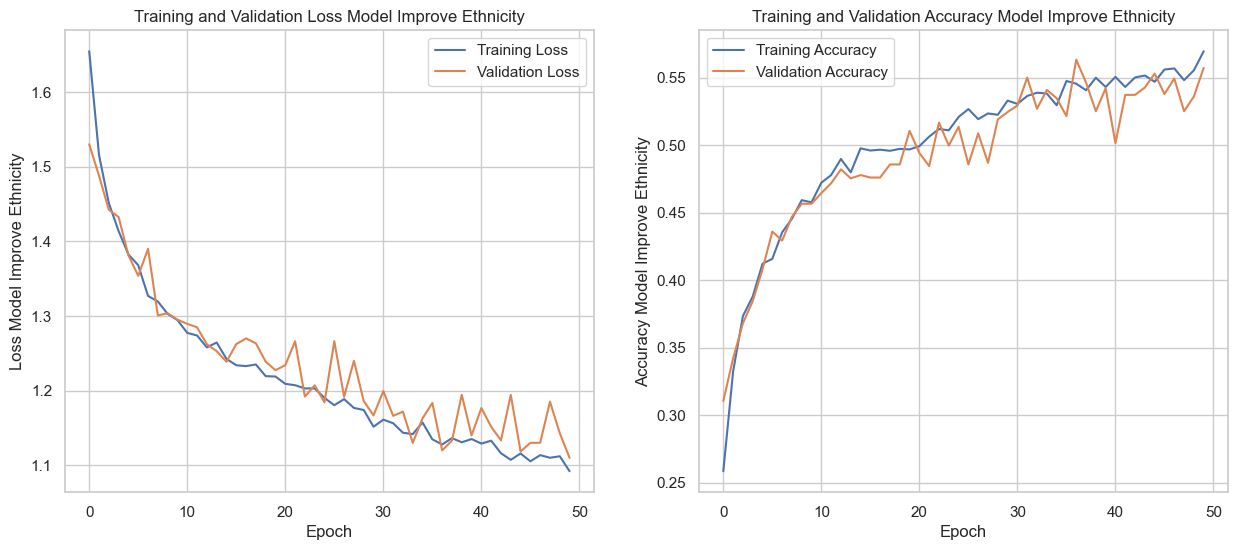

In [56]:
plot_training_history(history_ethnicity_transfer, 'Model Improve Ethnicity')

Model ini mengalami peningkatan dalam akurasi selama pelatihan, namun terdapat fluktuasi. Kehilangan (loss) cenderung menurun dari awal hingga akhir epoch. Meski akurasi pada data pelatihan meningkat, akurasi pada data validasi tetap stabil, menunjukkan adanya potensi overfitting yang perlu diperhatikan.

### Base & Improve Comparison for Ethnicity Model

|model|loss| acc | val_loss| val_acc|time|
| --- | --- |---|---|---|---|
|model_ethnicity | 1.2242 | 0.4924 | 1.2947 | 0.4663 |2m 4.1s|
|model_ethnicity_transfer| 1.0920 | 0.5696 | 1.1100 | 0.5573 |9m 43.6s|


Dari hasil yang diberikan, model "model_ethnicity_transfer" memiliki performa yang lebih baik dengan nilai akurasi yang lebih tinggi pada kedua data pelatihan dan validasi. Meskipun waktu pelatihan lebih lama, namun hasil yang diperoleh menunjukkan peningkatan kinerja. Oleh karena itu, saya menggunakan "model_ethnicity_transfer" sebagai pilihan terbaik.

## Training for Age

### Base Model

In [57]:
history_age = model_age.fit(
    train3, 
    epochs=50,  
    validation_data=val3, 
    batch_size=64, 
    callbacks=[early_stopping]
)

Epoch 1/50


99/99 [==============================] - 2s 17ms/step - loss: 1.6007 - accuracy: 0.2480 - val_loss: 1.5710 - val_accuracy: 0.2676
Epoch 2/50
99/99 [==============================] - 2s 15ms/step - loss: 1.5266 - accuracy: 0.3071 - val_loss: 1.4912 - val_accuracy: 0.3216
Epoch 3/50
99/99 [==============================] - 2s 16ms/step - loss: 1.4997 - accuracy: 0.3324 - val_loss: 1.4831 - val_accuracy: 0.3444
Epoch 4/50
99/99 [==============================] - 2s 16ms/step - loss: 1.4747 - accuracy: 0.3441 - val_loss: 1.4762 - val_accuracy: 0.3330
Epoch 5/50
99/99 [==============================] - 2s 15ms/step - loss: 1.4683 - accuracy: 0.3532 - val_loss: 1.4468 - val_accuracy: 0.3302
Epoch 6/50
99/99 [==============================] - 2s 16ms/step - loss: 1.4574 - accuracy: 0.3611 - val_loss: 1.4291 - val_accuracy: 0.3634
Epoch 7/50
99/99 [==============================] - 2s 16ms/step - loss: 1.4199 - accuracy: 0.3905 - val_loss: 1.3703 - val_accuracy: 0.3956
Epoch 8/50
99/99 [======

Melatih model klasifikasi usia (age) menggunakan data pelatihan (train3). Proses pelatihan dilakukan selama 50 epoch, dengan data validasi (val3) digunakan untuk memantau kinerja model. Batch size sebesar 64 digunakan untuk proses pelatihan, dan callback early stopping diimplementasikan untuk menghentikan pelatihan jika tidak ada peningkatan yang signifikan dalam nilai val_loss selama 10 epoch berturut-turut. Tujuan dari proses pelatihan ini adalah untuk mengoptimalkan model sehingga dapat mengklasifikasikan usia individu dengan akurasi yang baik, menggunakan pengetahuan yang diperoleh selama pelatihan.

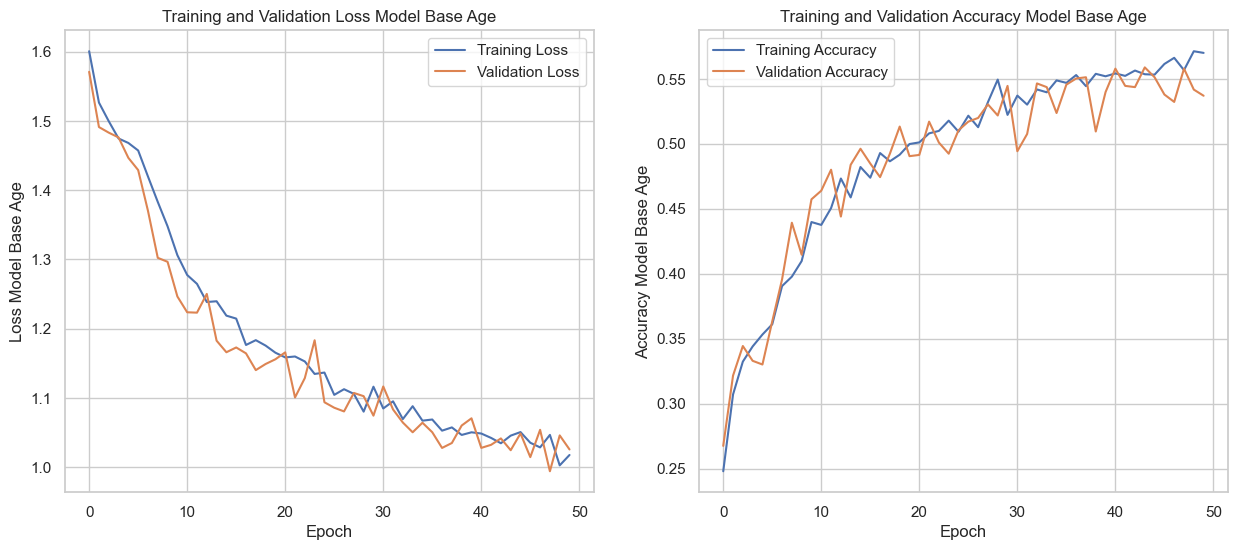

In [58]:
plot_training_history(history_age, 'Model Base Age')

Model CNN untuk klasifikasi umur menunjukkan fluktuasi selama pelatihan. Meskipun akurasi awalnya rendah tetapi terdapat peningkatan bertahap hingga mencapai puncak pada epoch terakhir. Meskipun terjadi peningkatan, terdapat potensi overfitting yang perlu diperhatikan

### Improve Model

In [59]:
history_age_transfer = model_age_transfer.fit(
    train3, 
    epochs=50,  
    validation_data=val3, 
    batch_size=64, 
    callbacks=[early_stopping]
)

Epoch 1/50


99/99 [==============================] - 12s 87ms/step - loss: 1.4904 - accuracy: 0.3785 - val_loss: 1.2916 - val_accuracy: 0.4459
Epoch 2/50
99/99 [==============================] - 8s 78ms/step - loss: 1.2677 - accuracy: 0.4585 - val_loss: 1.3152 - val_accuracy: 0.4573
Epoch 3/50
99/99 [==============================] - 8s 77ms/step - loss: 1.1953 - accuracy: 0.4869 - val_loss: 1.2846 - val_accuracy: 0.4649
Epoch 4/50
99/99 [==============================] - 7s 74ms/step - loss: 1.1453 - accuracy: 0.5122 - val_loss: 1.2460 - val_accuracy: 0.4896
Epoch 5/50
99/99 [==============================] - 7s 74ms/step - loss: 1.1350 - accuracy: 0.5071 - val_loss: 1.2548 - val_accuracy: 0.4829
Epoch 6/50
99/99 [==============================] - 7s 74ms/step - loss: 1.0988 - accuracy: 0.5292 - val_loss: 1.2625 - val_accuracy: 0.4943
Epoch 7/50
99/99 [==============================] - 7s 74ms/step - loss: 1.0844 - accuracy: 0.5273 - val_loss: 1.3250 - val_accuracy: 0.4820
Epoch 8/50
99/99 [=====

Melatih model transfer learning klasifikasi usia (age) menggunakan data pelatihan (train3). Proses pelatihan dilakukan selama 50 epoch, dengan data validasi (val3) digunakan untuk memantau kinerja model. Batch size sebesar 64 digunakan untuk proses pelatihan, dan callback early stopping diimplementasikan untuk menghentikan pelatihan jika tidak ada peningkatan yang signifikan dalam nilai val_loss selama 10 epoch berturut-turut. Model ini menggunakan transfer learning, memanfaatkan pengetahuan yang telah diperoleh dari model sebelumnya atau pre-trained model untuk meningkatkan kinerja klasifikasi usia. Tujuan dari proses pelatihan ini adalah untuk mengoptimalkan model transfer learning sehingga dapat mengklasifikasikan usia individu dengan akurasi yang lebih baik.

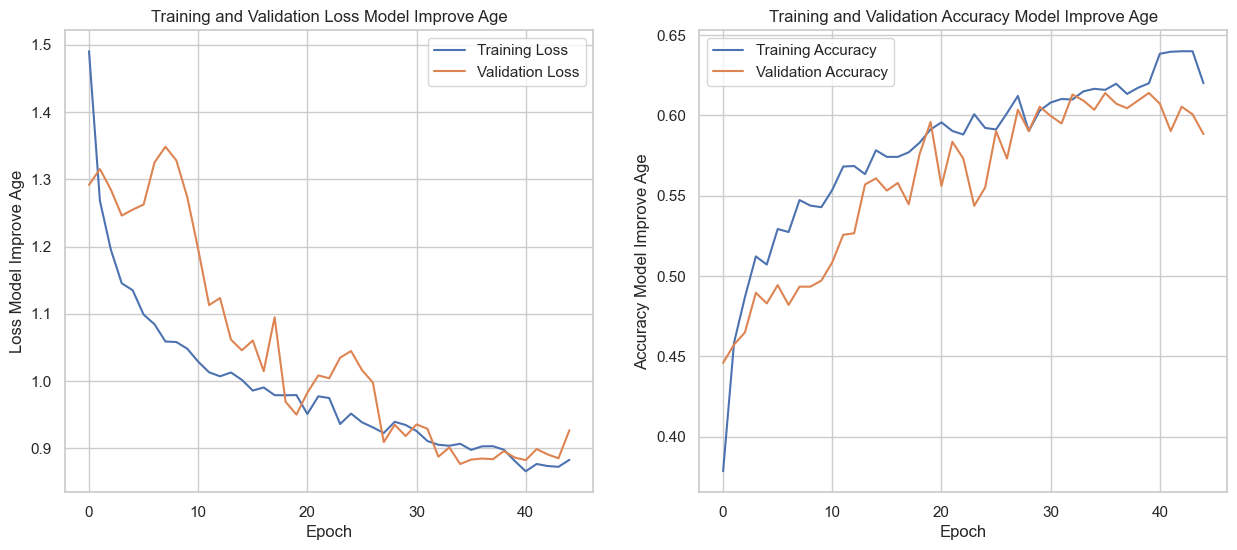

In [60]:
plot_training_history(history_age_transfer, 'Model Improve Age')

Model transfer learning untuk klasifikasi umur menunjukkan peningkatan kinerja yang konsisten selama pelatihan. Dengan akurasi awal cukup baik, model ini mengalami peningkatan signifikan dan mencapai akurasi tertinggi pada epoch terakhir. Peningkatan ini menunjukkan bahwa transfer learning dengan menggunakan model yang telah dilatih sebelumnya mampu mengenali pola-pola umum pada data umur.

Dengan demikian, berdasarkan hasil akhir, model transfer learning secara konsisten mengungguli model CNN konvensional untuk klasifikasi umur pada dataset ini. Transfer learning menawarkan keunggulan dalam memanfaatkan pengetahuan yang telah ada dari model sebelumnya, mempercepat dan meningkatkan kinerja model pada tugas klasifikasi umur.

### Base & Improve Comparison for Age Model

|model|loss| acc | val_loss| val_acc|time|
| --- | --- |---|---|---|---|
|model_age | 1.0177 | 0.5700 | 1.0258 | 0.5370 |1m 19.9s|
|model_age_transfer| 0.8828 | 0.6199 | 0.9268 | 0.5882 |5m 40.8s|


Dari hasil yang diberikan, "model_age_transfer" menunjukkan performa yang lebih baik dengan nilai akurasi yang lebih tinggi pada kedua data pelatihan dan validasi. Walaupun waktu pelatihan lebih lama dibandingkan "model_age," hasil yang diperoleh menunjukkan peningkatan kinerja yang signifikan. Oleh karena itu, saya menggunakan "model_age_transfer" sebagai pilihan terbaik.

# Model Evaluation

## Evaluation for Improve Model Gender

### Confusion Matrix Prediction Gender

In [81]:
y_pred_proba1 = model_gender_transfer.predict(X_test1)
y_pred1 = np.where(y_pred_proba1 >= 0.35, 1, 0)

  1/163 [..............................] - ETA: 6s

163/163 [==============================] - 4s 22ms/step


Hasil dari langkah sebelumnya berupa probabilitas untuk setiap kelas (dalam hal ini, kelas gender). Dengan menetapkan ambang batas probabilitas sebesar 0.4, kita membuat keputusan biner. Jika probabilitas kelas 1 ("male") lebih besar atau sama dengan 0.4, maka dianggap sebagai prediksi positif (1); sebaliknya, jika kurang dari 0.4, dianggap sebagai prediksi negatif (0).

Penggunaan ambang batas ini memungkinkan kita untuk mengontrol trade-off antara sensitivitas dan spesifisitas model.

In [62]:
def evaluate_and_plot(y_true, y_pred, labels, title):
    # Print Classification Report
    report = classification_report(y_true, y_pred)
    print(report)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

              precision    recall  f1-score   support

           0       0.69      0.70      0.70      2696
           1       0.67      0.67      0.67      2520

    accuracy                           0.68      5216
   macro avg       0.68      0.68      0.68      5216
weighted avg       0.68      0.68      0.68      5216



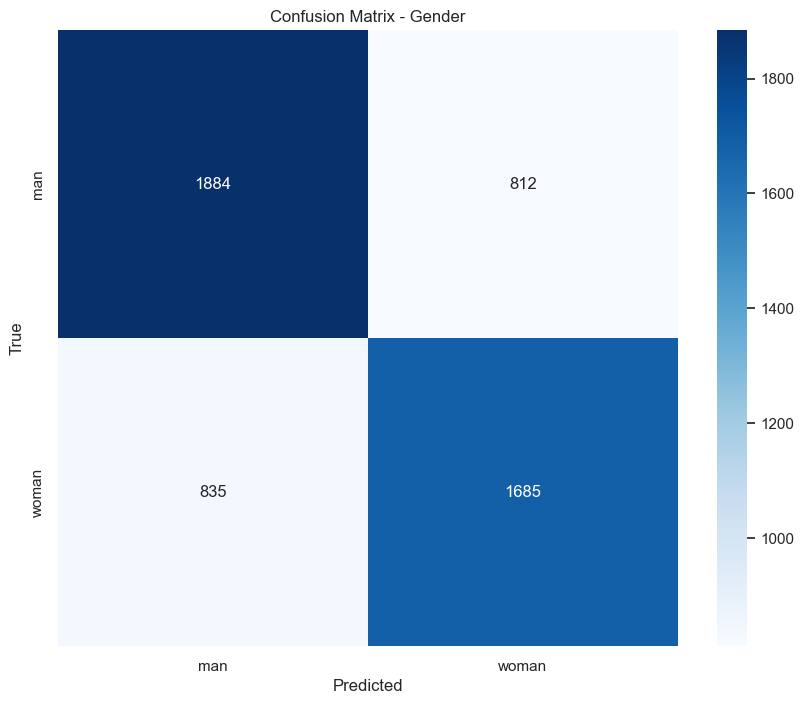

In [82]:
evaluate_and_plot(y_test1, y_pred1, ['man', 'woman'], 'Gender')

Model ini dapat dianggap cukup baik dalam mengklasifikasikan gender, dengan akurasi yang relatif baik. 

- True Positives : 1685 (67.5%)  - Jumlah prediksi benar bahwa individu adalah female.

- True Negatives : 1884 ( 70.5%) - Jumlah prediksi benar bahwa individu adalah male.

- False Positives : 812 (32.5%) - Jumlah prediksi yang salah bahwa individu adalah female padahal seharusnya male (Type I error).

- False Negatives : 835 (29.5%) - Jumlah prediksi yang salah bahwa individu adalah male padahal seharusnya female (Type II error).



### Characteristics False Negatif

In [64]:
def plot_custom_predictions(result_df, y_true, y_pred, category_name, condition_values):
    category = y_true.reset_index(drop=True)
    result = result_df.loc[y_true.index, ['pixels']].reset_index(drop=True)
    result[category_name] = category
    result['pred'] = y_pred
    
    actual = condition_values[0]
    prediction = condition_values[1]
    custom_predictions = result[(result[category_name] == actual) & (result['pred'] == prediction)]

    index_custom_predictions = custom_predictions.head(4).index

    plt.figure(figsize=(16, 16))
    for i, a in enumerate(index_custom_predictions):
        plt.subplot(4, 4, (i % 16) + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(result['pixels'].iloc[a].reshape(48, 48), cmap='gray')
        plt.xlabel(f"{category_name.capitalize()} Pred:{result['pred'].iloc[a]}  "
                   f"{category_name.capitalize()} Actual:{result[category_name].iloc[a]}")
    plt.show()

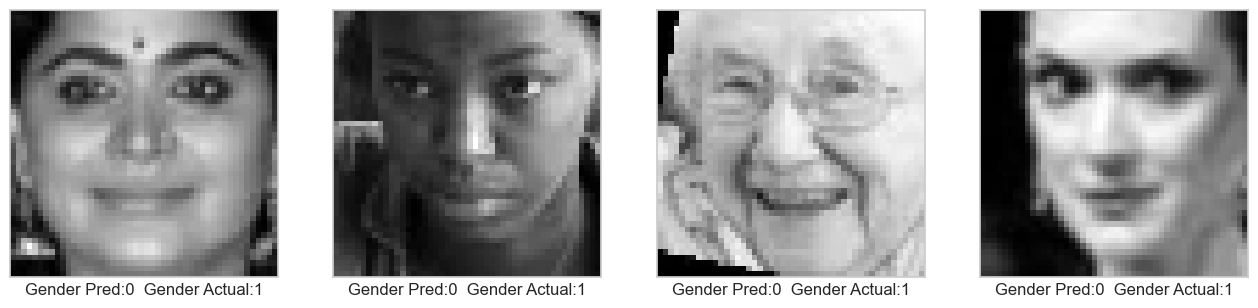

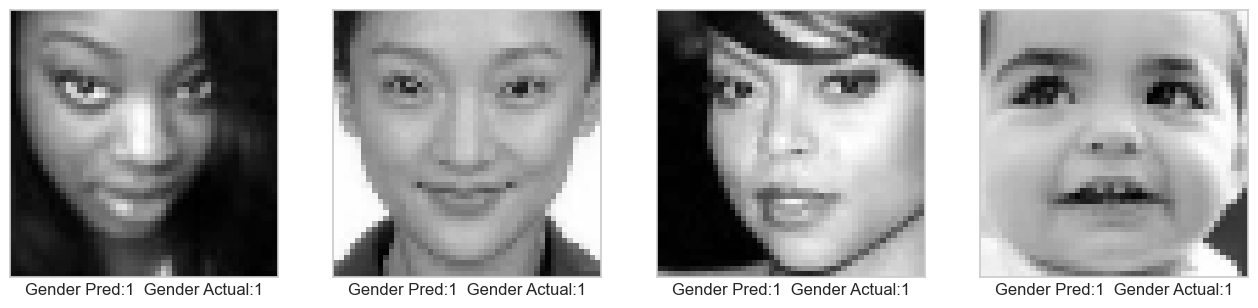

In [65]:
for i in ([1,0],[1,1]) :
    plot_custom_predictions(data, y_test1, y_pred1, 'gender', i)

Berdasarkan visual yang dibuat, asumsinya mungkin berkaitan dengan variasi dan kompleksitas fitur wajah individu yang sulit diidentifikasi secara akurat oleh model. Beberapa karakter wajah yang spesifik, seperti gaya rambut, aksesori, atau tata letak fitur wajah, mungkin menjadi faktor yang sulit diinterpretasi oleh model, terutama jika variasi ini tidak terwakili dengan baik dalam data pelatihan. Perbaikan mungkin melibatkan pengumpulan data lebih representatif atau penambahan fitur yang lebih mendalam untuk meningkatkan kinerja model terhadap kasus-kasus yang lebih kompleks.

### Characteristics False Positive

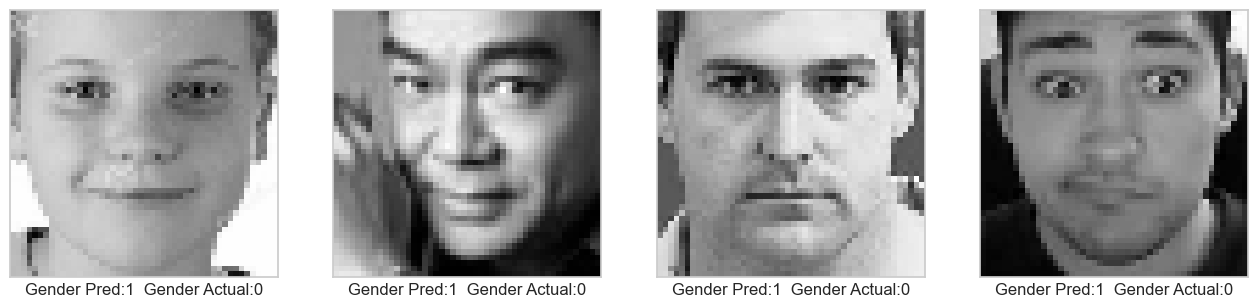

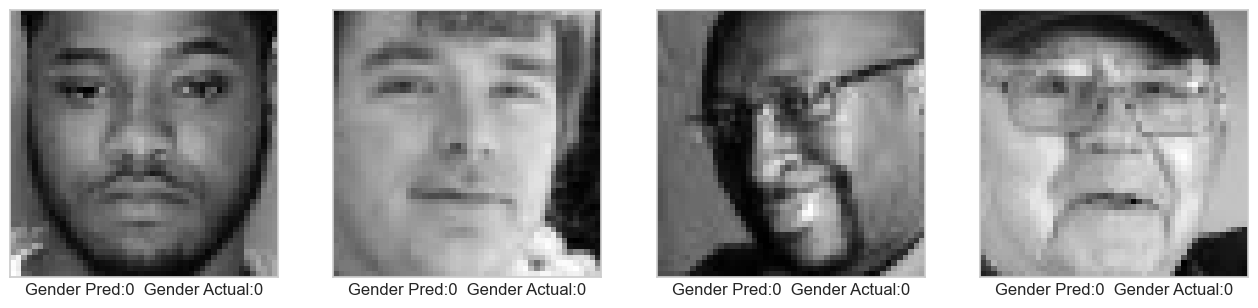

In [66]:
for i in ([0,1],[0,0]) :
    plot_custom_predictions(data, y_test1, y_pred1, 'gender', i)

Dari visual yang dibuat, asumsinya mungkin terkait dengan sulitnya model mengidentifikasi variasi dan kompleksitas fitur wajah individu, terutama yang tidak terwakili baik dalam data pelatihan, seperti identik hanya menilai dari berkumis atau brewok. Upaya perbaikan bisa melibatkan pengumpulan data lebih representatif atau peningkatan fitur untuk kasus yang lebih kompleks.

## Evaluation for Improve Model Ethnicity

### Confusion Matrix Prediction Ethnicity

In [67]:
y_pred_proba2 = model_ethnicity_transfer.predict(X_test2)
y_pred2 = np.argmax(y_pred_proba2, axis=1)

59/59 [==============================] - 2s 21ms/step


Hasil prediksinya disajikan dalam bentuk probabilitas (y_pred_proba2) dan label prediksi akhir (y_pred2) diambil dari indeks dengan probabilitas tertinggi untuk setiap sampel data.

              precision    recall  f1-score   support

           0       0.52      0.47      0.49       380
           1       0.70      0.60      0.65       367
           2       0.49      0.44      0.46       376
           3       0.37      0.51      0.43       371
           4       0.36      0.33      0.35       368

    accuracy                           0.47      1862
   macro avg       0.49      0.47      0.48      1862
weighted avg       0.49      0.47      0.48      1862



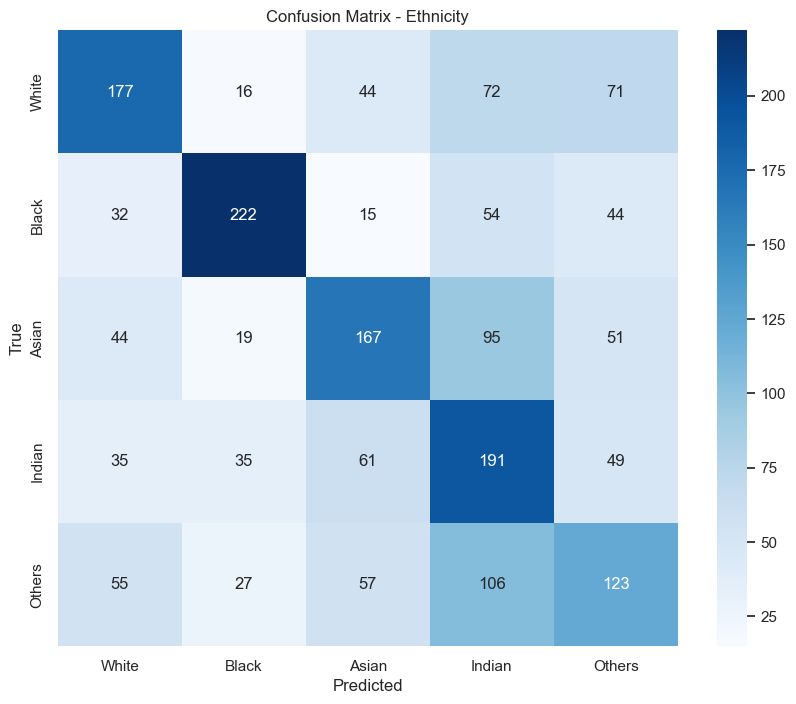

In [68]:
evaluate_and_plot(y_test2, y_pred2, ['White', 'Black', 'Asian', 'Indian', 'Others'], 'Ethnicity')

Model ini juga memiliki kinerja yang beragam dalam mengklasifikasikan kategori etnis:

- Etnis 1: Berhasil mengklasifikasikan dengan baik (177 TP), tetapi terdapat beberapa kesalahan dengan 44 FP dan 72 FN.

- Etnis 2: Model cenderung baik dalam mengklasifikasikan kategori ini, dengan 222 TP, 15 FP, dan 54 FN.

- Etnis 3: Cenderung baik dengan 167 TP, 95 FP, dan 51 FN.

- Etnis 4: Mengalami kesulitan dalam mengklasifikasikan kategori ini, ditandai dengan 191 TP, 61 FP, dan 49 FN.

- Etnis 5: Sangat baik dalam mengklasifikasikan kategori ini, dengan 123 TP dan hanya sedikit FP (57) dan FN (106).

### Caracteristic False

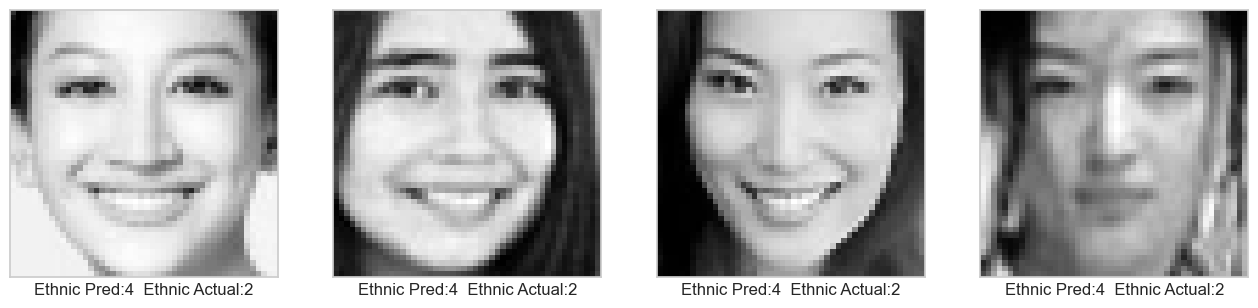

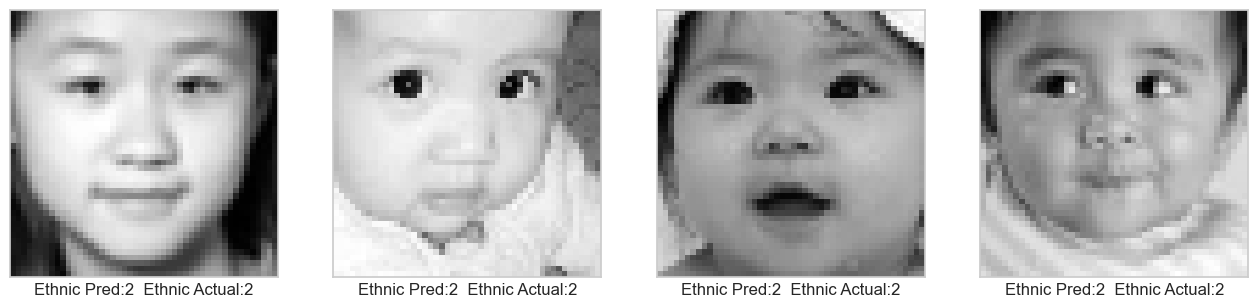

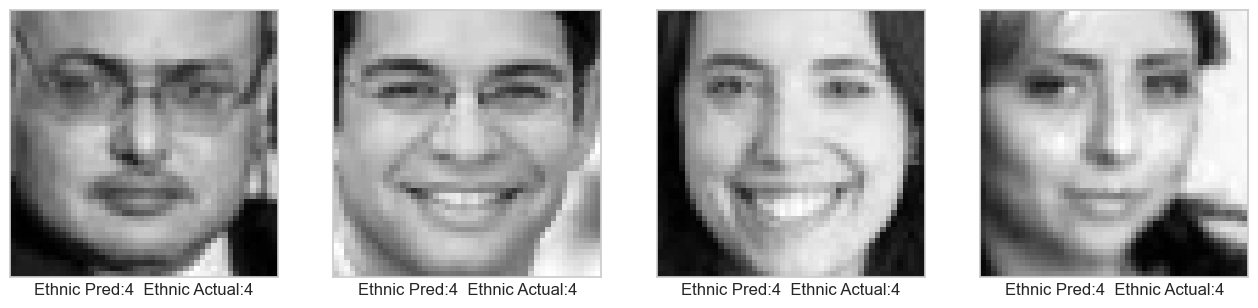

In [69]:
for i in ([2,4],[2,2],[4,4]) :
    plot_custom_predictions(ethnicity_df, y_test2, y_pred2, 'ethnic', i)

Mungkin saja model memiliki kesulitan membedakan antara etnis 4 (other) dan etnis 2 (Asian) karena adanya kemiripan visual yang signifikan di antara keduanya. Misalnya, karakteristik fisik tertentu, seperti bentuk mata, hidung, atau warna kulit, mungkin tidak cukup jelas atau konsisten dalam data pelatihan. Oleh karena itu, model cenderung melakukan prediksi yang kurang akurat untuk kasus tertentu di mana perbedaan antara etnis 4 dan etnis 2 tidak terlalu mencolok. Perbaikan mungkin melibatkan pengumpulan data lebih rinci yang menangkap nuansa perbedaan antar etnis dengan lebih baik.

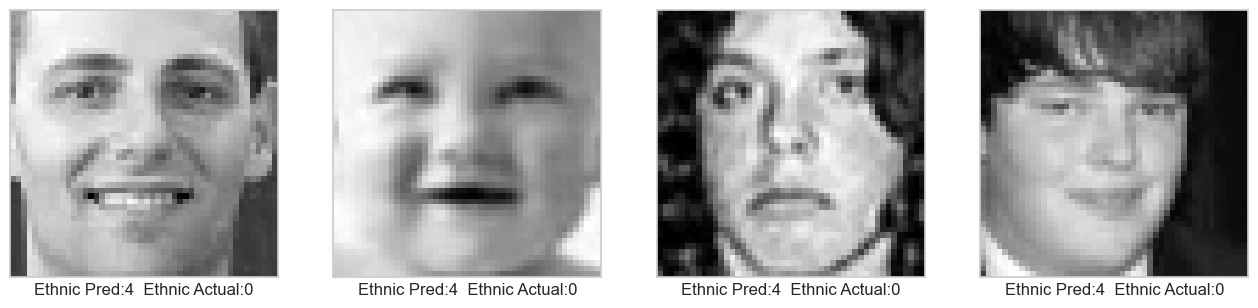

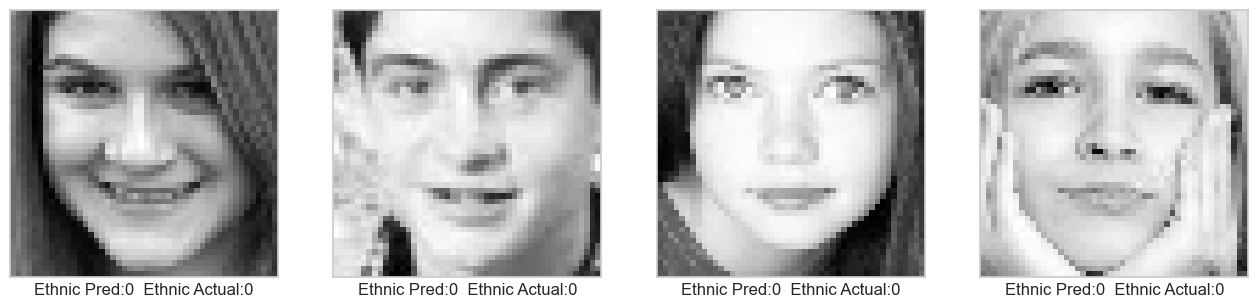

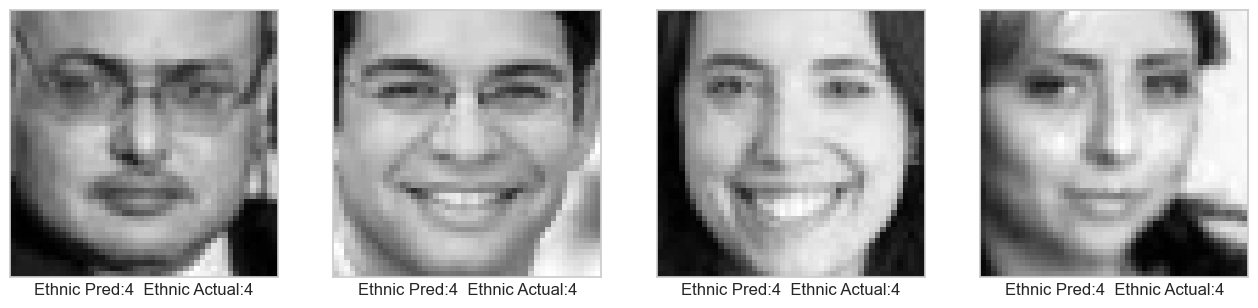

In [70]:
for i in ([0,4],[0,0],[4,4]) :
    plot_custom_predictions(ethnicity_df, y_test2, y_pred2, 'ethnic', i)

Model mungkin mengalami kesulitan membedakan antara etnis white (0) dan etnis other (4) karena warna kulit yang mungkin serupa di antara keduanya. Kedua kelompok tersebut dapat memiliki variasi warna kulit yang terlihat serupa dalam data pelatihan, sehingga model sulit untuk membedakannya secara akurat. Dalam hal ini, perbedaan fisik lainnya yang mungkin ada di antara keduanya tidak cukup terwakili dalam data, menyebabkan model menghasilkan prediksi yang kurang tepat. Solusi potensialnya mungkin melibatkan pengumpulan data yang lebih beragam dan peningkatan pemahaman model terhadap ciri-ciri wajah yang lebih halus.

## Evaluation for Improve Model Age

### Confusion Matrix Prediction Age

In [71]:
y_pred_proba3 = model_age_transfer.predict(X_test3)
y_pred3 = np.argmax(y_pred_proba3, axis=1)

38/38 [==============================] - 1s 22ms/step


              precision    recall  f1-score   support

           0       0.79      0.90      0.84       240
           1       0.61      0.50      0.55       224
           2       0.49      0.38      0.43       232
           3       0.63      0.65      0.64       247
           4       0.76      0.91      0.83       248

    accuracy                           0.68      1191
   macro avg       0.66      0.67      0.66      1191
weighted avg       0.66      0.68      0.66      1191



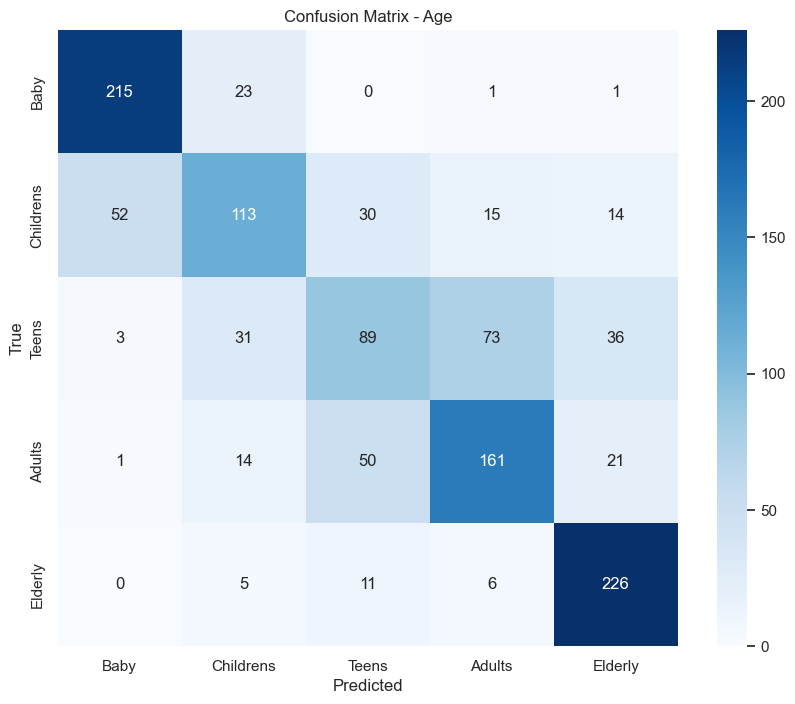

In [72]:
evaluate_and_plot(y_test3, y_pred3, ['Baby', 'Childrens', 'Teens', 'Adults', 'Elderly'], 'Age')

Model memiliki kinerja yang beragam dalam mengklasifikasikan kategori usia :

- Kategori Usia 1: Berhasil mengklasifikasikan dengan baik (215 TP), tetapi terdapat beberapa kesalahan dengan 23 FP dan 1 FN.

- Kategori Usia 2: Terdapat kesulitan dalam mengklasifikasikan kategori ini, terutama dengan 52 FP dan 30 FN.

- Kategori Usia 3: Cenderung baik dalam mengklasifikasikan kategori ini, dengan 89 TP, 73 FP, dan 36 FN.

- Kategori Usia 4: Mengalami kesulitan dalam mengklasifikasikan kategori ini, ditandai dengan 161 TP, 50 FP, dan 21 FN.

- Kategori Usia 5: Sangat baik dalam mengklasifikasikan kategori ini, dengan 226 TP dan hanya sedikit FP (11) dan FN (6).

### Caracteristic False

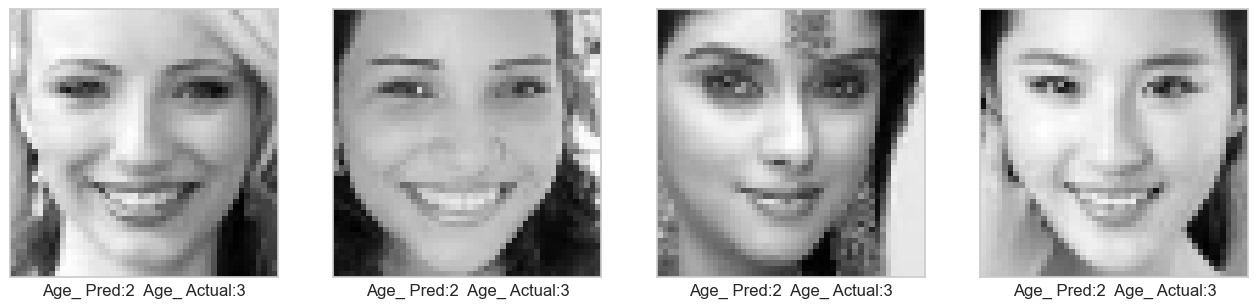

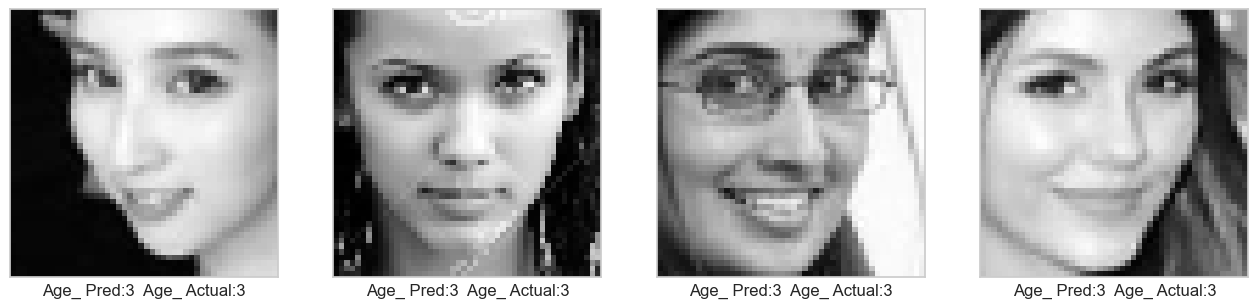

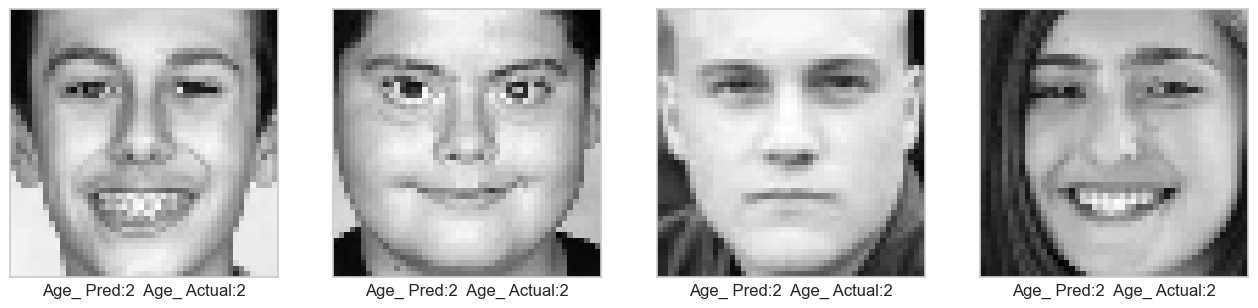

In [73]:
for i in ([3,2],[3,3],[2,2]) :
    plot_custom_predictions(age_df, y_test3, y_pred3, 'age_', i)

Model mungkin menghadapi tantangan dalam mengklasifikasikan antara kategori dewasa (label 3) (label 3) dan remaja (label 2) karena adanya variasi yang kompleks dalam fitur wajah di antara keduanya. Beberapa karakteristik wajah yang mungkin menjadi faktor kebingungan termasuk detail kecil seperti ekspresi, garis wajah, atau bahkan gaya rambut. Dalam beberapa kasus, perbedaan yang halus ini mungkin sulit diidentifikasi secara konsisten oleh model. Dengan demikian, terjadi kemungkinan terjadinya kesalahan di mana beberapa individu dewasa (label 3) diprediksi sebagai remaja (label 2) dan sebaliknya. Solusi untuk meningkatkan kinerja model dapat melibatkan pengumpulan data yang lebih representatif atau penyesuaian pada fitur-fitur yang dianggap rumit oleh model.

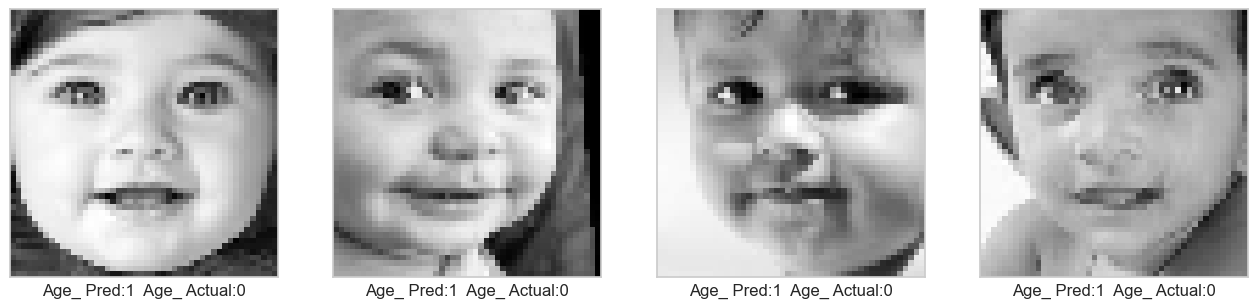

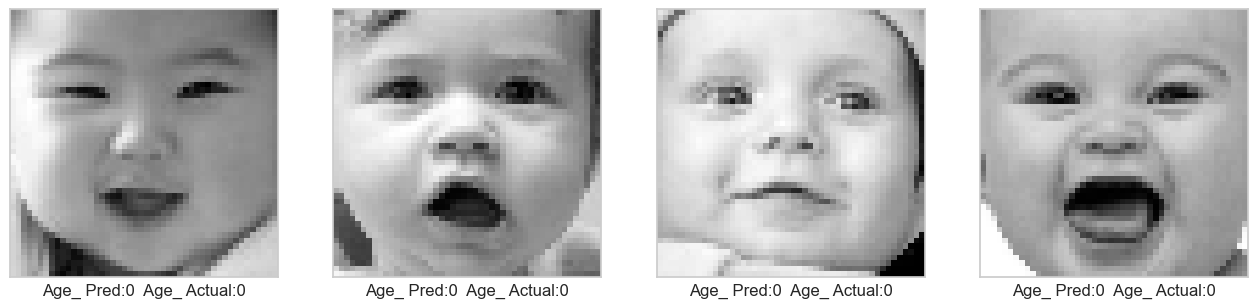

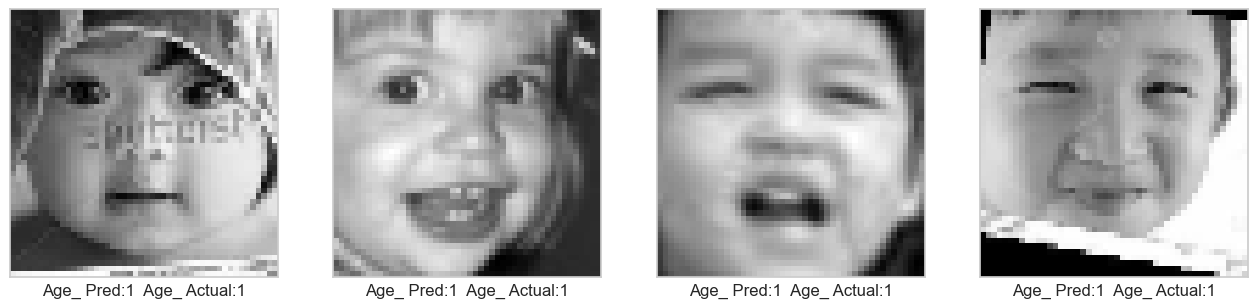

In [74]:
for i in ([0,1],[0,0],[1,1]) :
    plot_custom_predictions(age_df, y_test3, y_pred3, 'age_', i)

Model dapat mengalami kesulitan dalam mengklasifikasikan gambar bayi (label 0) sebagai anak-anak (label 1) karena perbedaan yang halus dalam fitur wajah antara kedua kategori tersebut. Bayi cenderung memiliki fitur wajah yang berbeda dari anak-anak (label 1) yang lebih tua, termasuk proporsi wajah yang berbeda, ukuran mata, dan detail kecil lainnya. Dalam beberapa kasus, model mungkin kesulitan menangkap perbedaan ini, sehingga terjadi kesalahan di mana beberapa gambar bayi (label 0) diprediksi sebagai anak-anak (label 1). Untuk meningkatkan kinerja model terhadap kasus ini, perlu dipertimbangkan untuk memperoleh lebih banyak data pelatihan yang mencakup variasi usia dan fitur wajah yang lebih baik merepresentasikan berbagai kelompok umur.

# Model Saving

In [91]:
model_gender_transfer.save('model_gender.keras')
model_ethnicity_transfer.save('model_ethnicity.keras')
model_age_transfer.save('model_age.keras')

menyimpan model terbaik untuk digunakan dalam memprediksi data inference atau data lain

# Model Inference

Dalam file P2G7_Muhammad-insani_Inference.ipynb

# Kesimpulan

## Terhadap Performance Model

Dari segi waktu pelatihan, model transfer learning cenderung membutuhkan waktu lebih lama, tetapi dapat memberikan peningkatan kinerja yang signifikan. Insight yang bisa diambil untuk keperluan bisnis:

>Gender Classification:

Model transfer learning lebih unggul dalam mengklasifikasikan gender dengan akurasi yang lebih tinggi.
Dalam bisnis yang berkaitan dengan segmentasi pasar berdasarkan gender, penggunaan model transfer learning dapat memberikan hasil yang lebih dapat diandalkan.

>Ethnicity Classification:

Model transfer learning memiliki performa yang lebih baik secara keseluruhan dalam mengklasifikasikan kategori etnis.
Pemilihan model transfer learning dapat memberikan informasi etnis yang lebih akurat dalam aplikasi seperti penelitian demografis atau pengembangan produk yang disesuaikan dengan keberagaman etnis.

>Age Classification:

Model transfer learning juga menunjukkan peningkatan kinerja dalam mengklasifikasikan kategori usia.
Untuk bisnis yang memerlukan penargetan berdasarkan kelompok usia, menggunakan model transfer learning dapat meningkatkan akurasi prediksi.

## Terhadap Kemajuan bisnis :

Penerapan model transfer learning untuk mengklasifikasikan gender, etnis, dan usia membawa dampak positif pada kemajuan bisnis. Dengan kemampuan yang lebih baik dalam mengidentifikasi karakteristik demografis pelanggan, bisnis dapat melakukan segmentasi pasar yang lebih akurat, memungkinkan strategi pemasaran yang lebih terfokus dan penawaran produk yang lebih personal. Personalisasi ini tidak hanya dapat meningkatkan retensi pelanggan tetapi juga mengoptimalkan pengalaman pengguna secara keseluruhan, menciptakan lingkungan online yang lebih sesuai dengan preferensi individu.

Selain itu, hasil yang lebih akurat dari model klasifikasi dapat digunakan untuk analisis demografis mendalam, memberikan wawasan yang berharga tentang perilaku konsumen dan tren pembelian. Dengan dasar informasi ini, bisnis dapat membuat keputusan strategis yang lebih terinformasi, membuka peluang untuk inovasi produk yang lebih efektif dan pengembangan strategi pemasaran yang lebih canggih. Keseluruhan, penggunaan model transfer learning tidak hanya memperkuat daya saing bisnis tetapi juga meningkatkan efisiensi operasional dan relevansi bisnis dalam memenuhi kebutuhan pelanggan secara lebih presisi.